# "Analyzing Patterns in Chicago Motor Vehicle Crashes Using Time-Series and Classification Techniques"
By: Christina Trotta
Faculty Mentor: Dr. Andrew Ross

### Table of Contents:

#### Section 1 - Introduction
#### Section 2 - Exploratory Data Analysis
#### Section 3 - Prophet Forcasting and Time-Series Analysis
#### Section 4 - Holt Winters Smoothing
#### Section 5 - Conclusion

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np
from sklearn.linear_model import LinearRegression
from prophet import Prophet

# Section 1 - Introduction

Understanding and forecasting traffic crashes is essential for improving public safety, resource allocation, and infrastructure planning. With Chicago’s vast and detailed traffic data available at the daily level, this project aimed to explore how past crash patterns — along with external variables like weather and roadway conditions — could be used to predict future crash rates. The central question driving this work was: "How much does yesterday’s crash rate help predict today’s?"

To answer this, we used time series modeling techniques including Holt-Winters exponential smoothing, Prophet forecasting, and SARIMAX regression. We engineered a clean, daily-level dataset of crashes from 2018 to 2024, incorporating binary flags for crash conditions and merging with weather data from both O’Hare and Midway airports. The project explored the predictive power of lagged crash data alone, as well as how factors like precipitation, lighting, and road defects might help improve forecasting accuracy.

This data comes from the City of Chicago's open data portal, which provides a wealth of information on traffic incidents. The dataset includes details such as the date, time, location, and severity of each crash, as well as contributing factors like weather conditions and road defects. By analyzing this data, we aimed to identify patterns and trends that could inform future traffic safety initiatives. It is recorded by the city government, not citizens, which should ensure a complete record of significant incidents. However, minor fender benders or unreported incidents may not be included in the dataset.

# Section 2 - Exploratory Data Analysis

In this section we will take a first glance at the data. Are there any obvious trends in the data? What should we expect from this data set? We need to pul summary statistics. Additionally, are there any obvious flaws with the data? It's important that we take into account any missing data, duplicate data, and handle it. 

In [11]:
# Load the raw data
df_raw = pd.read_csv("C:/Users/chris/Documents/Senior_Project/CT_SeniorProject/CrashData_Repo1/data/raw/raw_data.csv")

### General Data Trends and Descriptive Statistics


In [58]:
df_raw.info()     # Overview of column types and missing values
#df_raw.describe()   # Summary statistics for numeric columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910387 entries, 0 to 910386
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   CRASH_RECORD_ID                910387 non-null  object        
 1   CRASH_DATE_EST_I               67175 non-null   object        
 2   CRASH_DATE                     910387 non-null  datetime64[ns]
 3   POSTED_SPEED_LIMIT             910387 non-null  int64         
 4   TRAFFIC_CONTROL_DEVICE         910387 non-null  object        
 5   DEVICE_CONDITION               910387 non-null  object        
 6   WEATHER_CONDITION              910387 non-null  object        
 7   LIGHTING_CONDITION             910387 non-null  object        
 8   FIRST_CRASH_TYPE               910387 non-null  object        
 9   TRAFFICWAY_TYPE                910387 non-null  object        
 10  LANE_CNT                       199023 non-null  float64       
 11  

This is a preliminary test to see the general shape of the data. We can see the raw data has 910387 entries. There are 47 different fields in this data set. 

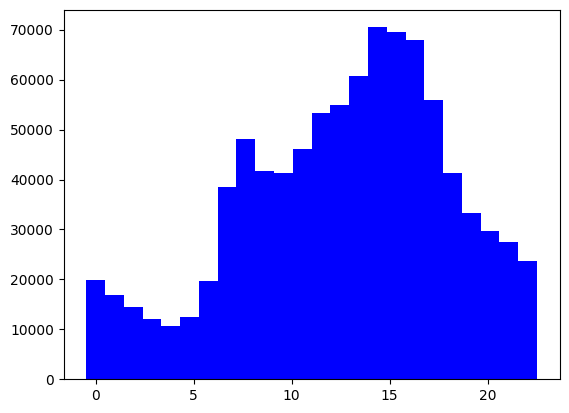

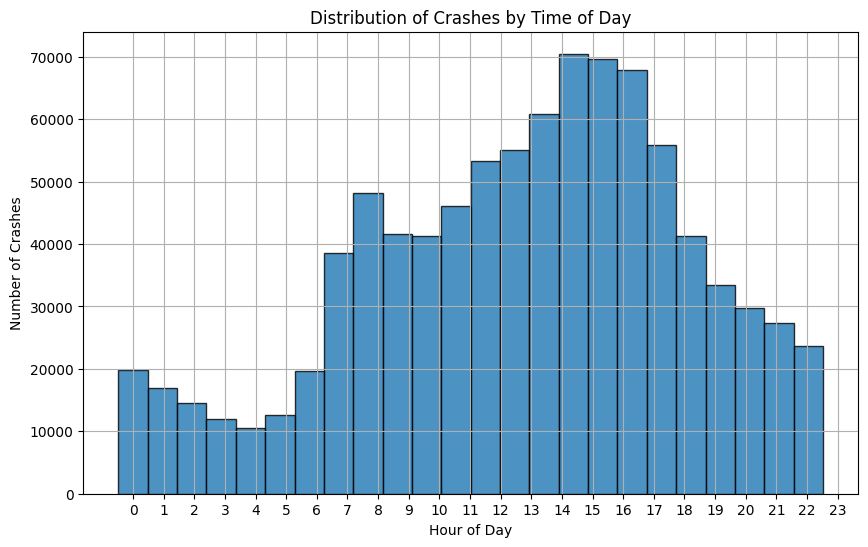

In [13]:
# Plot the distribution of 'CRASH_HOUR'
df_raw['CRASH_HOUR'].hist(bins=24, grid=False, color='blue', align='left')

# Define a function to categorize the time of day
def time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'


plt.figure(figsize=(10, 6))
plt.hist(df_raw['CRASH_HOUR'], bins=24, edgecolor='black', alpha=0.8, align='left')
plt.title('Distribution of Crashes by Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Crashes')
plt.xticks(range(0, 24))  # Set x-ticks to represent hours of the day (0-23)
plt.grid(True)
plt.show()


The histogram shows the frequency of crashes by hour of day. We see a large increase in the number of crashes around "rush hour", around the hours 2-6pm. Many people are commuting home from work during this time period. We also see an upward trend in crashes in the morning, around hours 7-10am. This increase compared to the early hours of the day again makes sense, due to the heavy increase in traffic for commuters on their way to work. The number of crashes during this timeframe 7-10am is similar to that during the 6-8pm timeframe. We can see a low number of crashes in the early hours of the day, from 12-5am. 

Questions from this initial histogram:
- How well does time/hour of day predict the probability/the number of car crashes?

1. How many crashes occurred in total, and how is this distributed by year or month? (Examine trends over time to identify whether crashes are increasing, decreasing, or remaining constant.) 

C:\Users\chris\AppData\Local\Temp\ipykernel_10316\2656098333.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_raw['CRASH_DATE'] = pd.to_datetime(df_raw['CRASH_DATE'])


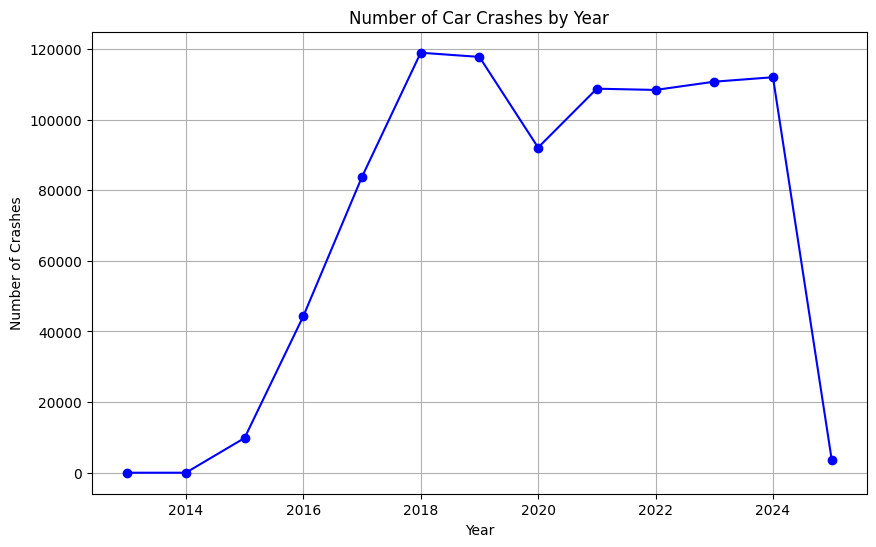

In [14]:
# Examine car crashes over time by year with a line graph
df_raw['CRASH_DATE'] = pd.to_datetime(df_raw['CRASH_DATE'])
df_raw['CRASH_YEAR'] = df_raw['CRASH_DATE'].dt.year

# Group by year and count the number of crashes
crashes_by_year = df_raw.groupby('CRASH_YEAR').size()

# Plot the data
plt.figure(figsize=(10, 6))
crashes_by_year.plot(kind='line', marker='o', color='blue')
plt.title('Number of Car Crashes by Year')
plt.xlabel('Year')
plt.ylabel('Number of Crashes')
plt.grid(True)
plt.show()

The above graph shows the number of car crashes by year. We can see a large increase in the number of crashes after 2015. This might not be extremely accurate however, since the graph is showing that the number of crashes in both 2013 and 2014 were both 0? Or a very small number. Let's dig a little further into these years to see what the data during this 2-year time span looks like.

In [15]:
# Return table of the number of crashes by year (only 2013 and 2014)
#crashes_by_year = df_filtered1314.groupby('CRASH_YEAR').size().reset_index(name='CRASH_COUNT')
crashes_by_year = df_raw.groupby('CRASH_YEAR').size().reset_index(name='CRASH_COUNT')
print(crashes_by_year)

    CRASH_YEAR  CRASH_COUNT
0         2013            2
1         2014            6
2         2015         9830
3         2016        44297
4         2017        83786
5         2018       118950
6         2019       117762
7         2020        92094
8         2021       108765
9         2022       108410
10        2023       110747
11        2024       112006
12        2025         3732


It seems like there is a discrepancy in the data reporting for years 2013 and 2014. This could be a reporting error, computer error, or perhaps the recording system was slowly being phased in throughout the city during this time. 

Since 2015, 2016, and 2017 are also a little bit low compared to years 2018-2024, we should remove these from further analysis as well. 

Additionally, since we don't have a full year's worth of data for 2025, we will also explude this data from our analysis. 

2. What is the average number of crashes per day, week, or month?

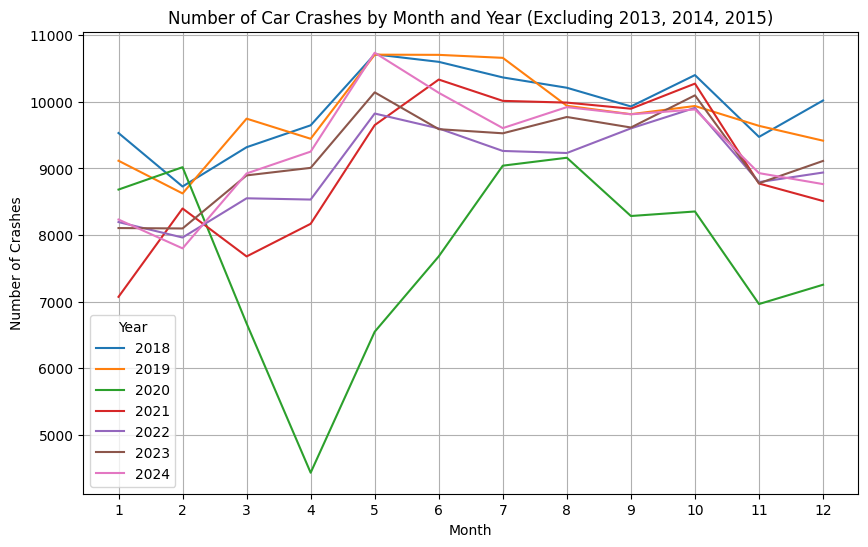

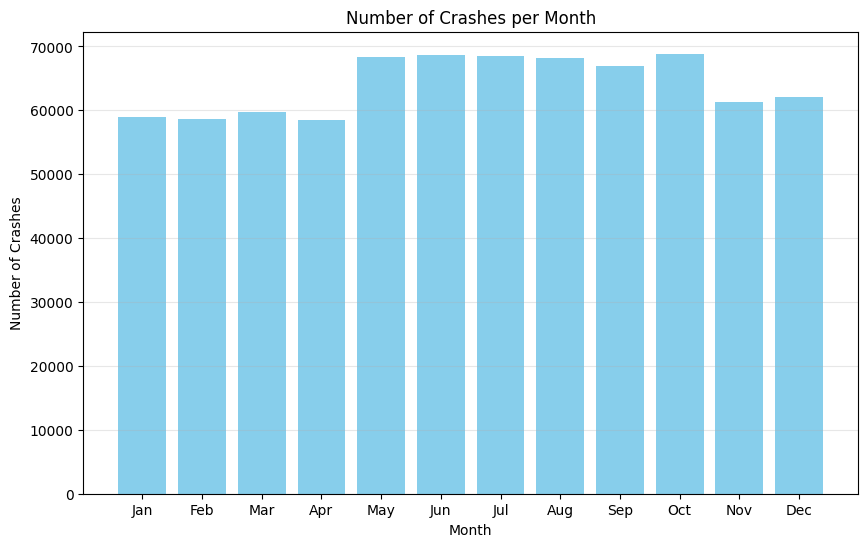

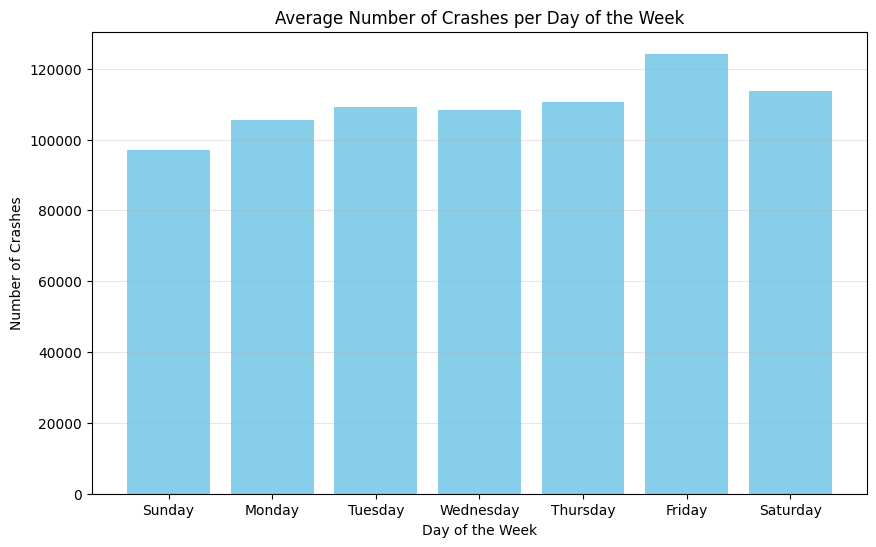

In [16]:
# Create a line graph of number of crashes by month, comparing the different lines by year

# Filter out the years 2013, 2014, and 2015
df_filtered = df_raw[~df_raw['CRASH_YEAR'].isin([2013, 2014, 2015, 2016, 2017, 2025])]

# Group by year and month, counting the number of crashes
monthly_crashes = df_filtered.groupby(['CRASH_YEAR', 'CRASH_MONTH']).size().reset_index(name='crash_count')

# Pivot the data so each year is a column
monthly_crashes_pivot = monthly_crashes.pivot(index='CRASH_MONTH', columns='CRASH_YEAR', values='crash_count')

# Plot the data
plt.figure(figsize=(10,6))

# Plot each year as a separate line
for year in monthly_crashes_pivot.columns:
    plt.plot(monthly_crashes_pivot.index, monthly_crashes_pivot[year], label=str(year))

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Number of Crashes')
plt.title('Number of Car Crashes by Month and Year (Excluding 2013, 2014, 2015)')
plt.xticks(monthly_crashes_pivot.index)  # Ensures all months are labeled
plt.legend(title="Year")
plt.grid(True)

# Show the plot
plt.show()

# Crashes by month
#df_filtered = df[~df['CRASH_YEAR'].isin([2013, 2014, 2015, 2016])]
crashes_per_day = df_filtered.groupby('CRASH_MONTH').size().reset_index(name='CRASH_COUNT')

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(crashes_per_day['CRASH_MONTH'], crashes_per_day['CRASH_COUNT'], color='skyblue')
plt.title('Number of Crashes per Month')
plt.xlabel('Month')
plt.ylabel('Number of Crashes')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y', alpha=0.3)
plt.show() 

crashes_per_day = df_filtered.groupby('CRASH_DAY_OF_WEEK').size().reset_index(name='CRASH_COUNT')

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(crashes_per_day['CRASH_DAY_OF_WEEK'], crashes_per_day['CRASH_COUNT'], color='skyblue')
plt.title('Average Number of Crashes per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crashes')
plt.xticks(range(1, 8), ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.grid(axis='y', alpha=0.3)
plt.show()

We can begin to see some trends in the monthly data, such as higher crash rates in the summer than in the winter, but the trends aren't as obvious or strong as we might expect them to be. Similarly, we can see some trends in the weekly bar chart, indicating that as the week goes on, there are more and more crashes. Again, this trend is not as string as we thought. We will continue to explore this with our time-series modeling. 

# Section 3: Prophet Forecasting and Time Series Analysis

In [17]:
# Use filtered data set
df = pd.read_csv("C:/Users/chris/Documents/Senior_Project/CT_SeniorProject/CrashData_Repo1/data/interim/filtered_dataset.csv")


### Check for missing data

Before we begin our analysis, is there a significant amount of missing data? Are there days where there are no crashes? We should check to see if there is data every day during this timeframe. 

In [18]:
# Check for missing data: Look at difference in time between records and plot d/t

# Create new df to look at time differences (and only including certain columns)
columns_to_keep = [ # selected columns to keep for analysis
    "CRASH_DATETIME", "CRASH_DATE", "CRASH_TIME", "CRASH_DAY_OF_WEEK", "Day_Of_Year",
    "Hour_Of_Day", "Hour_Of_Week", "LATITUDE", "LONGITUDE",
    "WEATHER_CONDITION", "LIGHTING_CONDITION"
]
# Create a new DataFrame with selected columns
df_time_diff = df[columns_to_keep].copy()

# Compute the time difference (Δt) between consecutive crashes in minutes
df_time_diff['CRASH_DATETIME'] = pd.to_datetime(df_time_diff['CRASH_DATETIME'])
df_time_diff['Time_Difference'] = df_time_diff['CRASH_DATETIME'].diff().dt.total_seconds() / 60  # Convert to minutes

# Drop the first row since the first time difference is NaN
df_time_diff = df_time_diff.dropna()

# Reset index for clarity
df_time_diff = df_time_diff.reset_index(drop=True)

# Return top 50 maximum time differences
print(df_time_diff['Time_Difference'].nlargest(50)) #in minutes

287935    277.0
424268    244.0
24037     231.0
251132    221.0
564161    219.0
123246    215.0
263872    214.0
211318    204.0
564710    202.0
532823    201.0
264935    200.0
420593    196.0
157571    193.0
265103    191.0
444921    191.0
464600    190.0
484548    190.0
728558    188.0
224531    185.0
500424    185.0
551930    184.0
237619    180.0
434522    180.0
435476    180.0
437667    180.0
546227    180.0
262232    178.0
417920    175.0
261954    173.0
142385    172.0
237078    170.0
583514    167.0
646320    167.0
246490    165.0
754845    163.0
260822    162.0
638455    162.0
49347     160.0
261196    160.0
315584    158.0
479901    158.0
314875    157.0
148645    156.0
334675    156.0
122384    155.0
267287    155.0
316532    155.0
327887    155.0
171812    154.0
683537    153.0
Name: Time_Difference, dtype: float64


The largest time gap in this dataset is only a couple of hours (277 minutes). We can assume that there are no significant issues with this data and proceeed with our time-series analysis. 

### Begin time-series analysis 

  CRASH_DATE  Total_Crashes
0 2018-01-01            337
1 2018-01-02            452
2 2018-01-03            383
3 2018-01-04            360
4 2018-01-05            373


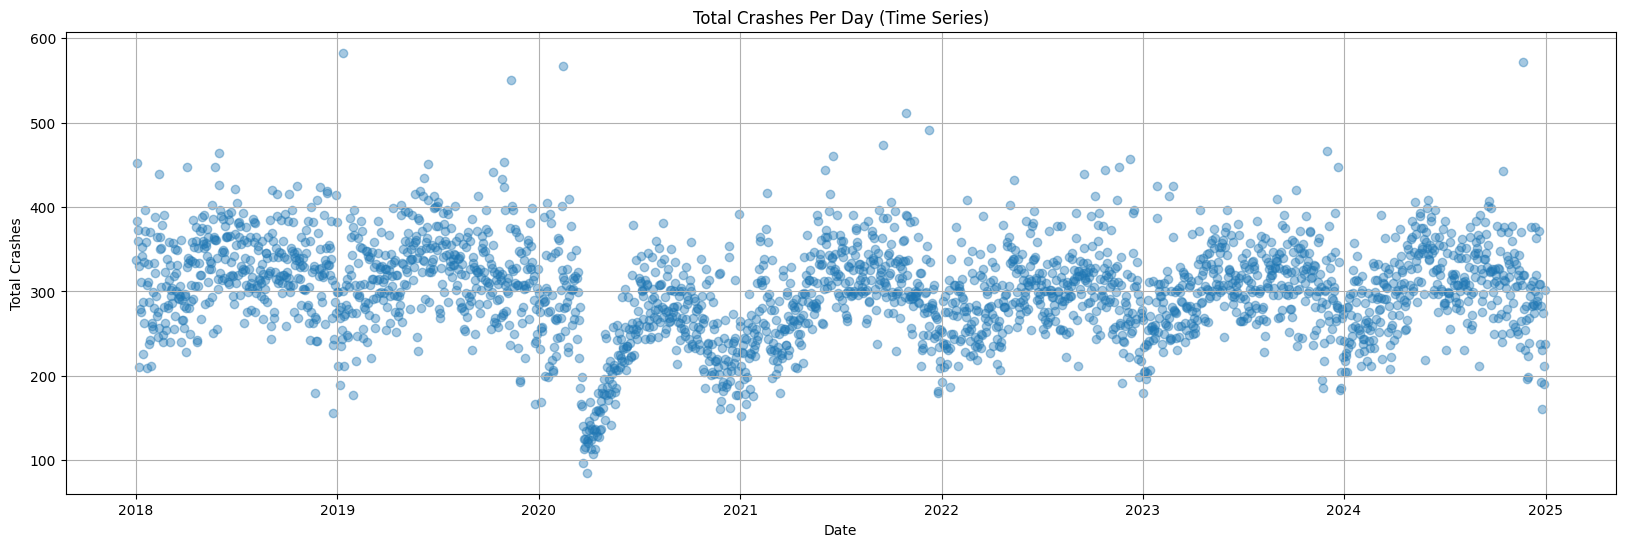

In [19]:
# Ensure CRASH_DATE is in datetime format (if not already)
df['CRASH_DATE'] = pd.to_datetime(df['CRASH_DATE'])

# Aggregate total crashes per day
df_crashes_per_day = df.groupby("CRASH_DATE").size().reset_index(name="Total_Crashes")

# Display the first few rows
print(df_crashes_per_day.head())

# Plot total crashes per day
plt.figure(figsize=(20, 6))
plt.scatter(df_crashes_per_day["CRASH_DATE"], df_crashes_per_day["Total_Crashes"], alpha=0.4)
plt.xlabel("Date")
plt.ylabel("Total Crashes")
plt.title("Total Crashes Per Day (Time Series)")
plt.grid(True)
plt.show()

Here we can see the aggregated Total Crashes Per Day graph, and we can see some trends starting to show themselves. Each year, there appears to be an upside-down U shaped pattern - meaning decreased crash rates in the winter and higher in the summer. We can also see a huge dip in the crash rates in early 2020. Let's fit a Fourier Regression curve to this dataset, as it looks approximately sinusoidal.

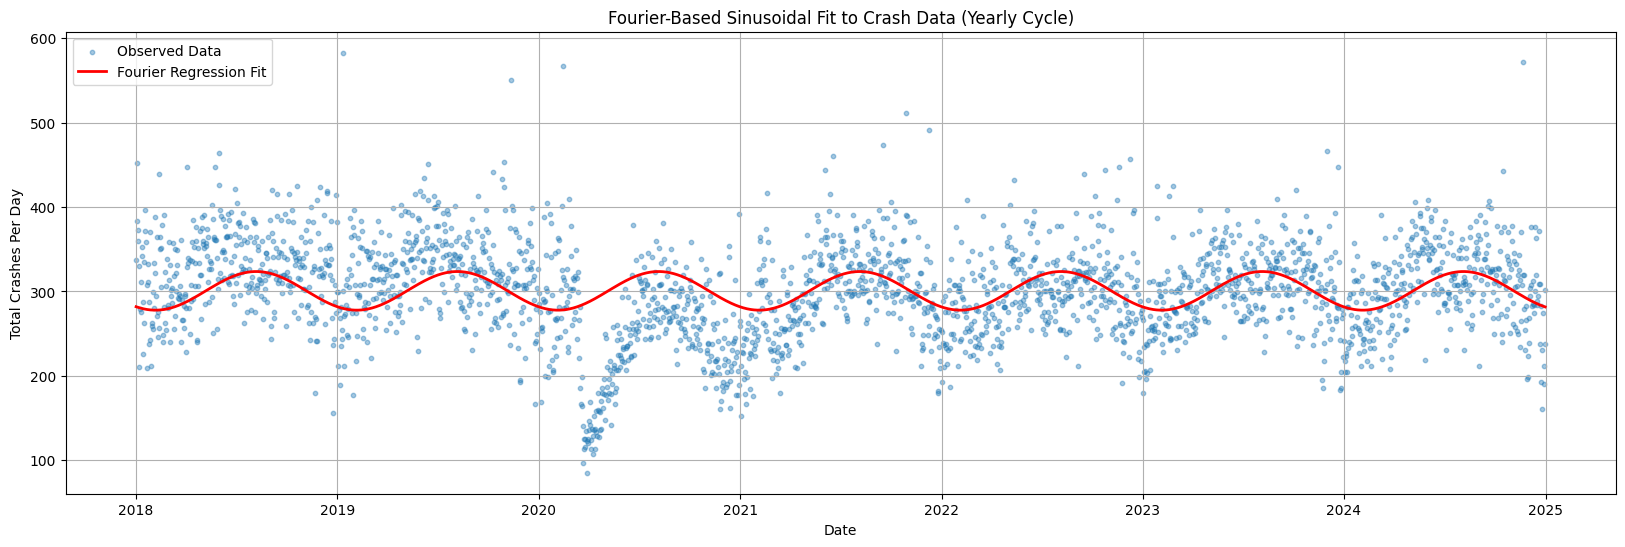

In [20]:
# Convert date to number of days since the start
df_crashes_per_day["Days_Since_Start"] = (df_crashes_per_day["CRASH_DATE"] - df_crashes_per_day["CRASH_DATE"].min()).dt.days

# faurier regression equations: A + Bsin(2πt/P) + Ccos(2πt/P)
# A, B, and C are coefficients
# t is the time variable (days since start)
# P is the period of the cycle (365 days for yearly cycle)


# Define the cycle period (365 days for yearly)
P = 365

# Create sine and cosine terms
df_crashes_per_day["Sin_Term"] = np.sin(2 * np.pi * df_crashes_per_day["Days_Since_Start"] / P)
df_crashes_per_day["Cos_Term"] = np.cos(2 * np.pi * df_crashes_per_day["Days_Since_Start"] / P)

# Define X (independent variables) and Y (dependent variable)
X = df_crashes_per_day[["Sin_Term", "Cos_Term"]]  # Features (sin & cos terms)
y = df_crashes_per_day["Total_Crashes"]  # Target variable

# Fit the linear regression model
reg = LinearRegression()
reg.fit(X, y)

# Get coefficients
A = reg.intercept_
B, C = reg.coef_

# Generate predictions
df_crashes_per_day["Fourier_Prediction"] = A + B * df_crashes_per_day["Sin_Term"] + C * df_crashes_per_day["Cos_Term"]

# Plot the results
plt.figure(figsize=(20, 6))
plt.scatter(df_crashes_per_day["CRASH_DATE"], df_crashes_per_day["Total_Crashes"], alpha=0.4, s=10, label="Observed Data")
plt.plot(df_crashes_per_day["CRASH_DATE"], df_crashes_per_day["Fourier_Prediction"], color="red", linewidth=2, label="Fourier Regression Fit")
plt.xlabel("Date")
plt.ylabel("Total Crashes Per Day")
plt.title("Fourier-Based Sinusoidal Fit to Crash Data (Yearly Cycle)")
plt.legend()
plt.grid(True)
plt.show()

What does this graph show us?

This graph helps to predict crash rates based on time of year. It is only accounting for monthly cycles, and not weekly cycles. For example, the curve is evaluating each day as if they were the same, not evaluating based on weekly seasonality, such as a Sunday in January. 

### Prophet Forecasting

Prophet is a package developed by Meta to forecast time series data. It is designed to handle missing data and outliers, and it can also incorporate seasonality and holidays into the forecasting model. Prophet is particularly useful for time series data that exhibits strong seasonal patterns and several seasons of historical data.

Prophet is a good choice for this data because it can handle the missing data and outliers that are present in the dataset. It can also incorporate seasonality and holidays into the forecasting model, which is important for this data. 


          ds    y  Days_Since_Start  Sin_Term  Cos_Term  Fourier_Prediction
0 2018-01-01  337                 0  0.000000  1.000000          281.828518
1 2018-01-02  452                 1  0.017213  0.999852          281.606744
2 2018-01-03  383                 2  0.034422  0.999407          281.390614
3 2018-01-04  360                 3  0.051620  0.998667          281.180192
4 2018-01-05  373                 4  0.068802  0.997630          280.975541


23:31:24 - cmdstanpy - INFO - Chain [1] start processing
23:31:25 - cmdstanpy - INFO - Chain [1] done processing


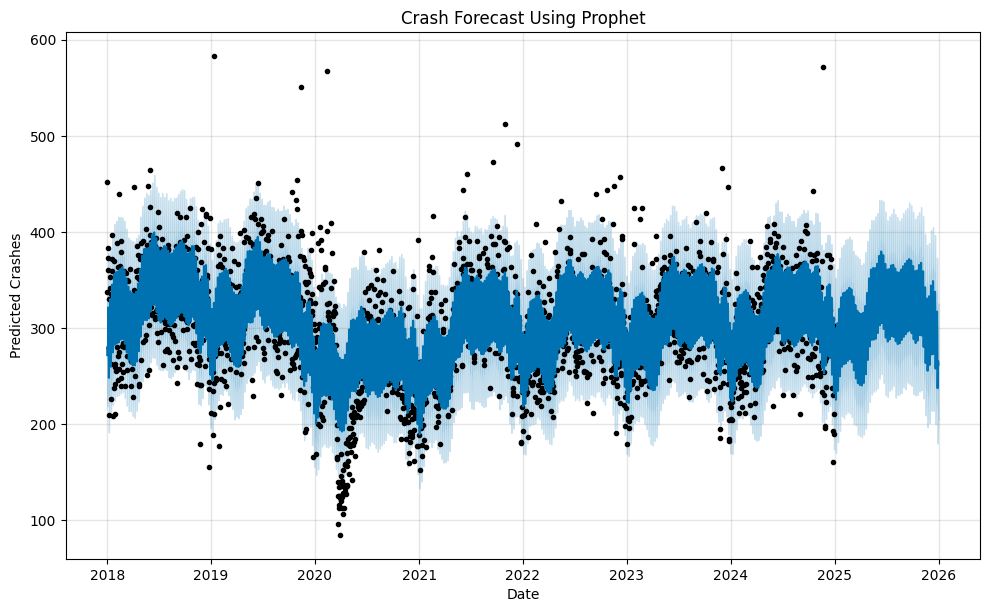

In [21]:
df_prophet = df_crashes_per_day.rename(columns={"CRASH_DATE": "ds", "Total_Crashes": "y"})
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"]) # date formatting
print(df_prophet.head())

# Initialize Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

# Fit the model
model.fit(df_prophet)

# Create future dates for the next 365 days
future = model.make_future_dataframe(periods=365)

# Forecast
forecast = model.predict(future)

# Display forecasted values
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

# Plot forecast
model.plot(forecast)
plt.title("Crash Forecast Using Prophet")
plt.xlabel("Date")
plt.ylabel("Predicted Crashes")
plt.grid(True)
plt.show()

Crash Forecast results:

This graph shows the predicted number of crashes per day 2018 through 2026, and was modeled on the data from 2018-2024.

Key Components of the Graph
- Black Dots =  Observed Data (Actual recorded crashes per day).
- Dark Blue Line = Model’s Predicted Trend (yhat), showing the expected number of crashes.
- Light Blue Shaded Area = Uncertainty Interval (confidence range for predictions).
-- Darker blue = Higher confidence in the forecast.
-- Lighter blue (outer edges) = Higher uncertainty in future predictions.

What This Forecast Tells Us

 1. The Model Captures Seasonality Well
- The trend clearly shows repeated dips and rises within each year, suggesting strong weekly and yearly seasonal patterns.
- Notice the dip in 2020—this aligns with COVID-19 lockdowns, when fewer people were on the road.

 2. Model Confidence Decreases in the Future
- The blue shaded area expands as we move further into the future (2025-2026).
- This makes sense because as time goes on, uncertainty increases, and Prophet reflects this by widening the confidence intervals.

 3. The Model Predicts a Stable Trend in Crashes
- Despite short-term variations, the long-term trend is relatively stable, meaning crashes are not increasing or decreasing significantly.

 4. The Model Handles Extreme Values Reasonably
- Some black dots (actual crash counts) are well outside the prediction intervals, which means occasional extreme values (high or low crash days) are not fully captured by the model.
- This suggests the presence of outliers or events (e.g., holidays, storms) that weren’t explicitly modeled.

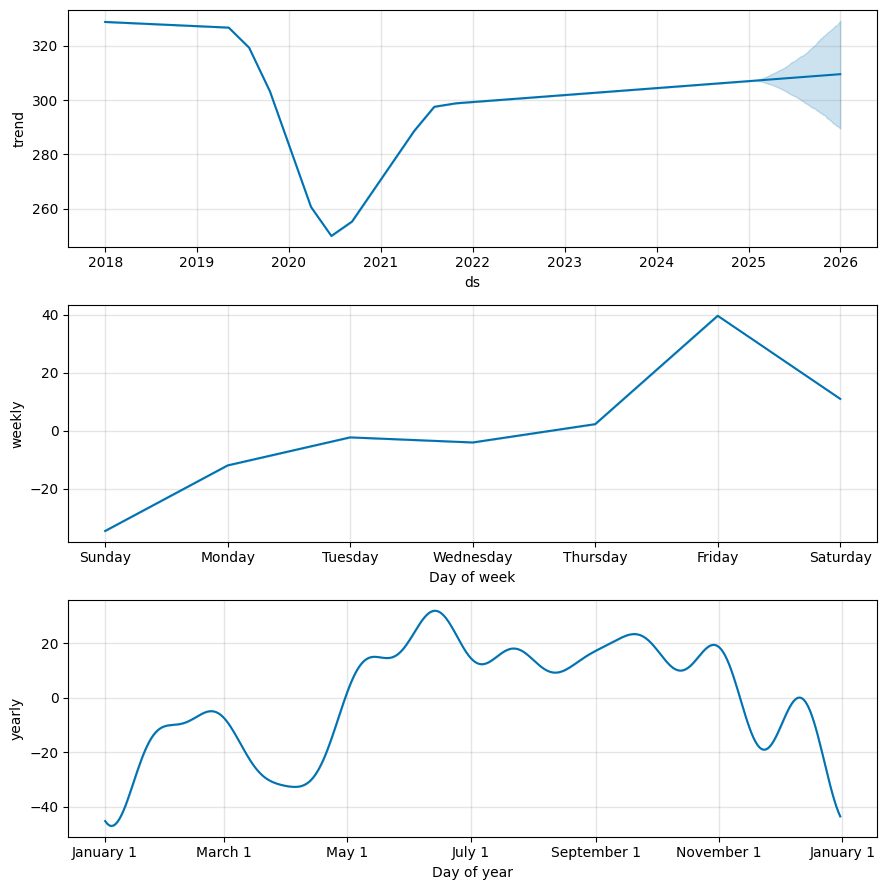

In [22]:
model.plot_components(forecast)
plt.show()

Let's interpret each of the three components plots:

1. Trend Component:

- This graph shows the general trend in crash rates over time. 
- There is a sharp dip in 2020 which corresponds to the COVID19 lockdowns, where fewer cars were on the road. 
- After 2021, crash rates return to pre-pandemic levels with a slight upward trend.
- The blue shaded area at the end represents the forecast for crash rates in 2025-2026. 

2. Weekly Seasonality Component:
 
- This graph shows crash trends for each day of the week
- Friday has the highest number of crashes, while Sunday has the lowest
- There's a steady increase in crashes from Sunday to Friday, and then a drop on Saturday
- These patterns seem to align with common driving behaviors (workweek vs weekend traffic)

3. Yearly Seasonality Component:

- This graph shows how crash rates fluctuate throughout the calendar year.
- Crashes are lowest in January, likely due to low travel rates in the winter in Chicago
- Crash rates peak around late spring and early summer (May-July). This aligns with more driving during the summer months (and more tourists)
- Another peak in September-November. This is possibly due to increased travel and holiday traffic, and perhaps school schedules.
- Sharp decline after Thanksgiving and December holidays.

Let's compute the residuals on the main graph above. 
* The model is taking account of weekly/yearly cycles so we should see if there's any patterns left. (There might be some autocorrelation)


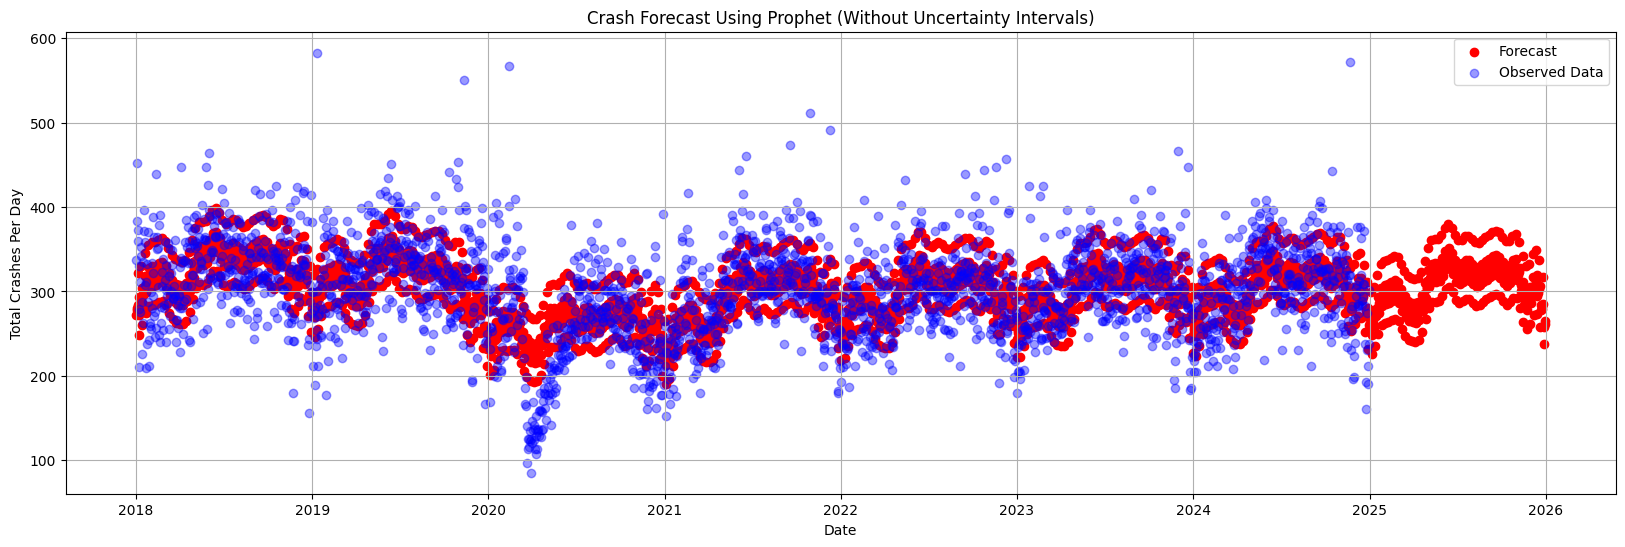

In [23]:
# Plot forecast (without the upper and lower bounds)
plt.figure(figsize=(20, 6))
plt.scatter(forecast["ds"], forecast["yhat"], color="red", label="Forecast")
plt.scatter(df_prophet["ds"], df_prophet["y"], alpha=0.4, color="blue", label="Observed Data")
plt.xlabel("Date")
plt.ylabel("Total Crashes Per Day")
plt.title("Crash Forecast Using Prophet"
" (Without Uncertainty Intervals)")
plt.legend()
plt.grid(True)
plt.show()

This graph shows us the predicted vs actual crash rate values. We can see in the prediction for 2025 that there are 3 different "layers" of the forcast. This is probably due to the highest crash rates around Fridays, and the lowest around Sundays. 

23:31:29 - cmdstanpy - INFO - Chain [1] start processing
23:31:29 - cmdstanpy - INFO - Chain [1] done processing


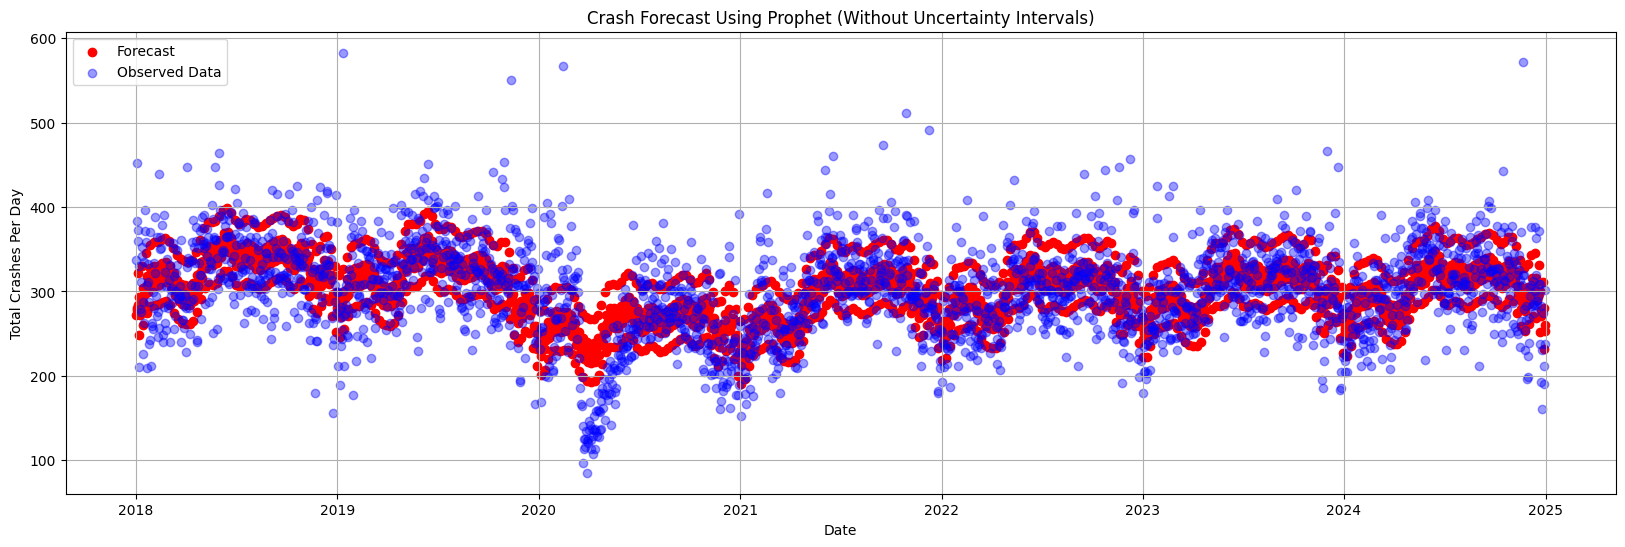

In [24]:
# run forecast on just 2018-2024 data NO FUTURE DATA
# Filter data to only include 2022-2024 (excluding COVID years)
df_prophet_filtered_18_24 = df_prophet[df_prophet["ds"].dt.year.isin([2018,2019,2020,2021,2022, 2023, 2024])].copy()

# Initialize Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

# Fit the model on 2022-2024 data
model.fit(df_prophet_filtered_18_24)

# create scatterplot predictions vs observed data
forecast_18_24 = model.predict(df_prophet_filtered_18_24)

# Plot forecast (without the upper and lower bounds)
plt.figure(figsize=(20, 6))
plt.scatter(forecast_18_24["ds"], forecast_18_24["yhat"], color="red", label="Forecast")
plt.scatter(df_prophet_filtered_18_24["ds"], df_prophet_filtered_18_24["y"], alpha=0.4, color="blue", label="Observed Data")
plt.xlabel("Date")
plt.ylabel("Total Crashes Per Day")
plt.title("Crash Forecast Using Prophet (Without Uncertainty Intervals)")
plt.legend()
plt.grid(True)
plt.show()

The graph shows the forecasted vs the actual crash rate data. We can see the large dip in 2020 due to COVID shutdowns and how that compares to what the model expected during that time. Additionally, after 2020, we can continue to see a small dip in the forecast every March. Because of the rate decreases due to the COVID shutdowns, the model now assumes that every MArch there will be a large decrease in crash rates. 

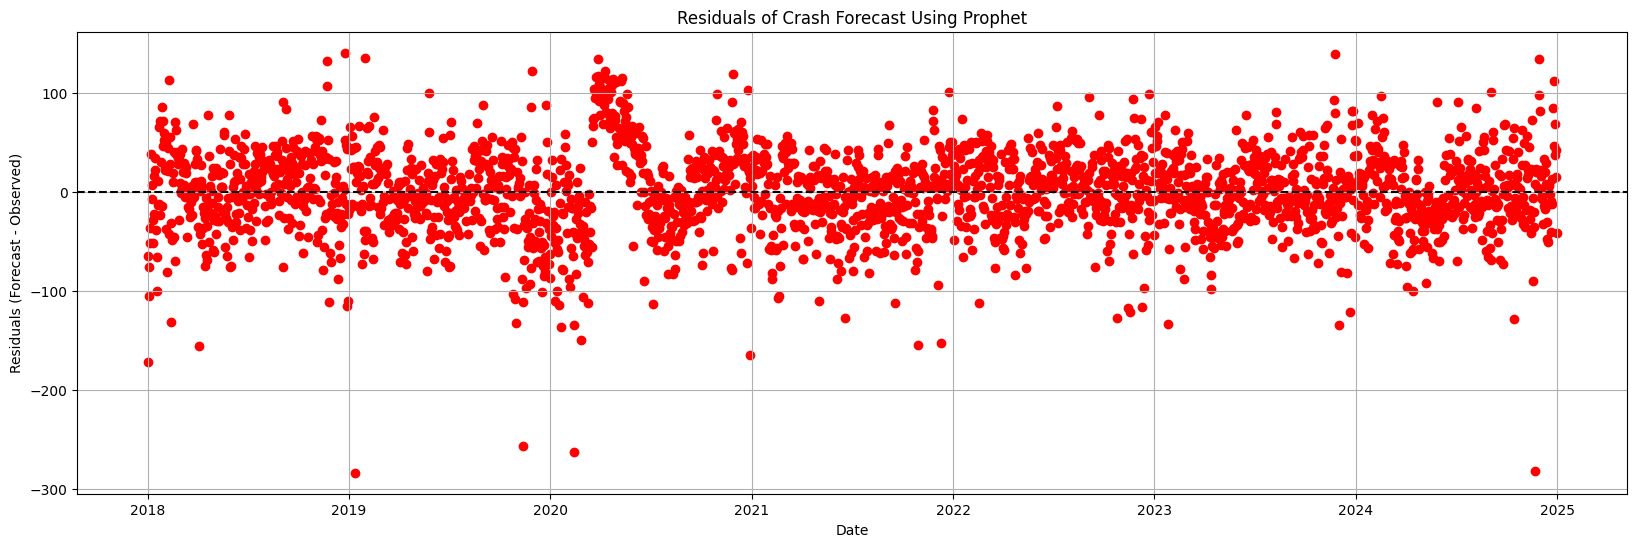

In [25]:
# Plot residuals (forecast - observed)
plt.figure(figsize=(20, 6))
plt.scatter(forecast["ds"], forecast["yhat"] - df_prophet["y"], color="red")
plt.axhline(y=0, color="black", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Residuals (Forecast - Observed)")
plt.title("Residuals of Crash Forecast Using Prophet")
plt.grid(True)
plt.show()


This graph shows the residuals of the Prophet forecast. We are looking for there to be little trends or patterns in the residuals. Overall, there are no patterns in these points. This means that the model is accounting for the various seasonal patterns within the data.

In March of 2020 you can see where the model overpredicted, and as it readjusted itself, it began to underpredict the amount of crashes. 

There also seem to be some extreme values where the prediction was way off (Jan 2019, Nov 2019, Feb 2020, Nov 2024). What is the significance of these days?

In [26]:
# find RMSE of the forecast
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = mean_squared_error(df_prophet_filtered_18_24["y"], forecast_18_24["yhat"], squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 42.38


c:\Users\chris\Documents\Senior_Project\CT_SeniorProject\.venv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


The Root Mean Squared Error is used to evaluate the accuracy of model prediction. This value is measured in crashes per day. The RMSE of the Prophet model (using all data from 2018-2024) is 42.38 crashes per day. That means we can expect the typical size of the prediction errors to be 42 crashes using this model. 

23:31:31 - cmdstanpy - INFO - Chain [1] start processing
23:31:32 - cmdstanpy - INFO - Chain [1] done processing


          ds        yhat  yhat_lower  yhat_upper
0 2022-01-01  240.171026  196.083964  287.095052
1 2022-01-02  200.081308  154.467520  247.217707
2 2022-01-03  212.919908  170.569165  257.384451
3 2022-01-04  228.338073  182.381171  274.304781
4 2022-01-05  227.807076  182.729161  272.281244


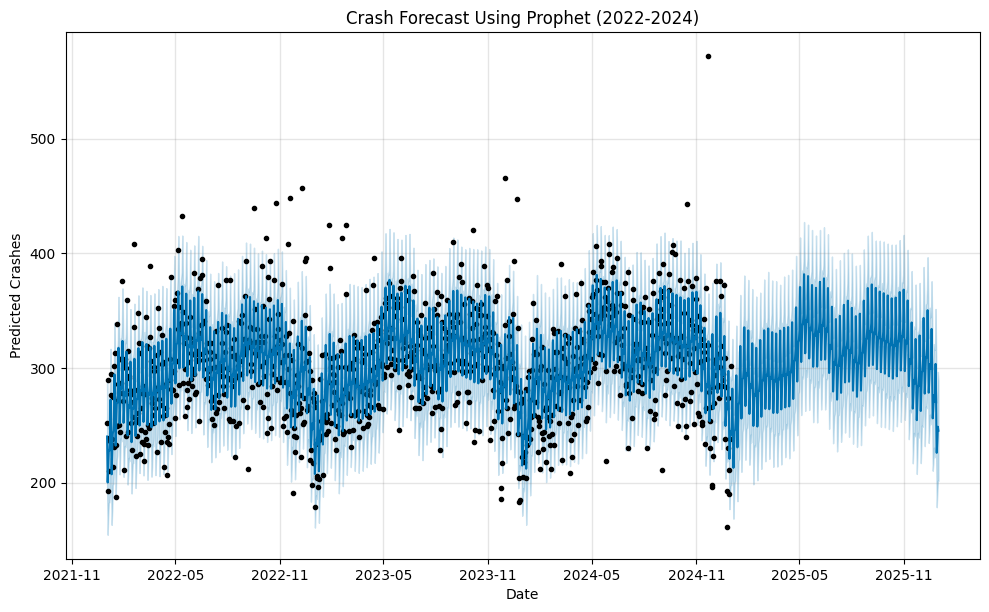

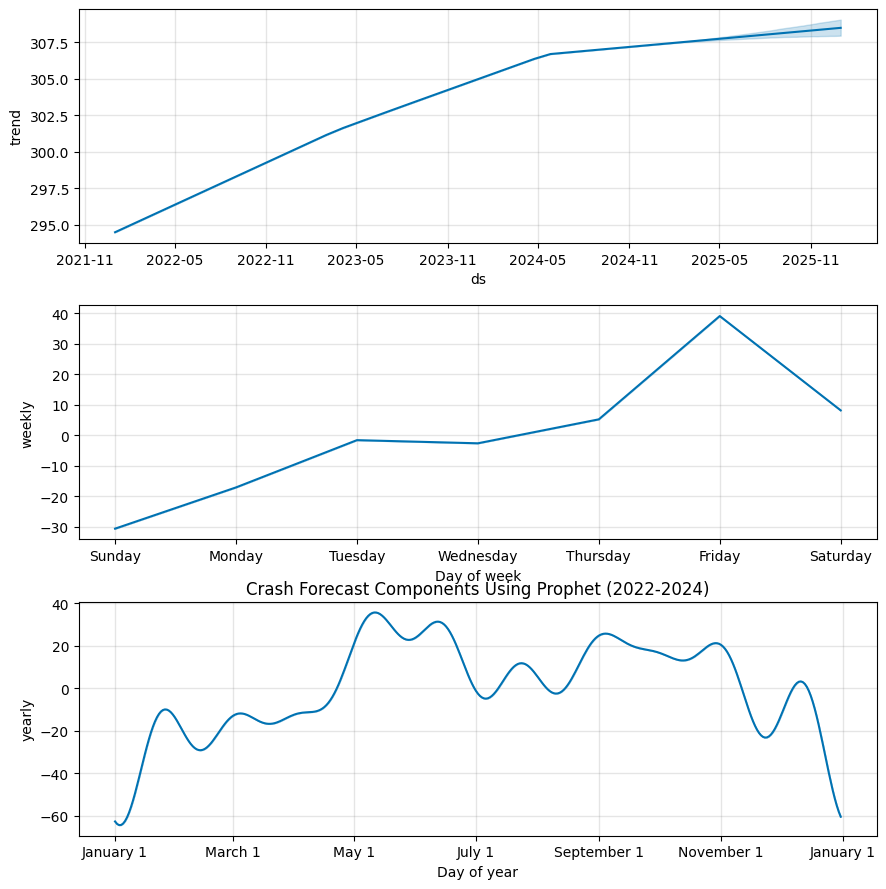

In [27]:
# Filter data to only include 2022-2024 (excluding COVID years)
df_prophet_filtered = df_prophet[df_prophet["ds"].dt.year.isin([2022, 2023, 2024])].copy()

# Initialize Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

# Fit the model on 2022-2024 data
model.fit(df_prophet_filtered)

# Create future dates for the next 365 days (1 year forecast)
future = model.make_future_dataframe(periods=365) # using future includes all dates from df_prophet_filtered AND future dates for 2025

# Forecast
forecast_22_24 = model.predict(future) #forecast contains past and future predictions
    # this includes all training data (ds values from df_prophet_filtered) and future dates (ds values from future)

# Display forecasted values
print(forecast_22_24[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

# Plot forecast
model.plot(forecast_22_24)
plt.title("Crash Forecast Using Prophet (2022-2024)")
plt.xlabel("Date")
plt.ylabel("Predicted Crashes")
plt.grid(True)
plt.show()


# Show trend and seasonality components
model.plot_components(forecast_22_24)
plt.title("Crash Forecast Components Using Prophet (2022-2024)")
plt.show()

Results of forecasting on 2022-2024 data:

The forecast graph shows the forecast for 2025 using only the data from 2022-2024 as it's training data. Because of the change in patterns during 2020-2021, it was best not to inlcude these years in our predictions. 

We can see that the model predicts similar trends for 2025 - low rates in the winter, and rates peaking in May.

It's also important to note that the model no longer predicts a large dip in the data in March 2025. When the COVID data was included, the model incorrectly predicts that each following year will also have a large dip in crash rates starting in March. 

The component graphs tell us about each of the seasonality trends detected by the model: 

- The yearly trend shows an overall increase in crashes each year. The margin of error (shaded in light blue) has a very small area and, compared to the model that used 2018-2024 data, has a very narrow prediction on future data. Since we had less error in this model, the prediction error is much smaller.
- The weekly trend is similar to that from the previous model - low rates on Sundays, rates increasing throughout the work week, and rates peaking on Fridays.
- The monthly trend shows interesting patterns. There are very low rates in December and January, and high rates in May and June. It's interesting that the curve of this graph is not smoother, and that we might think that July would also have equally as high of rates as May and June.

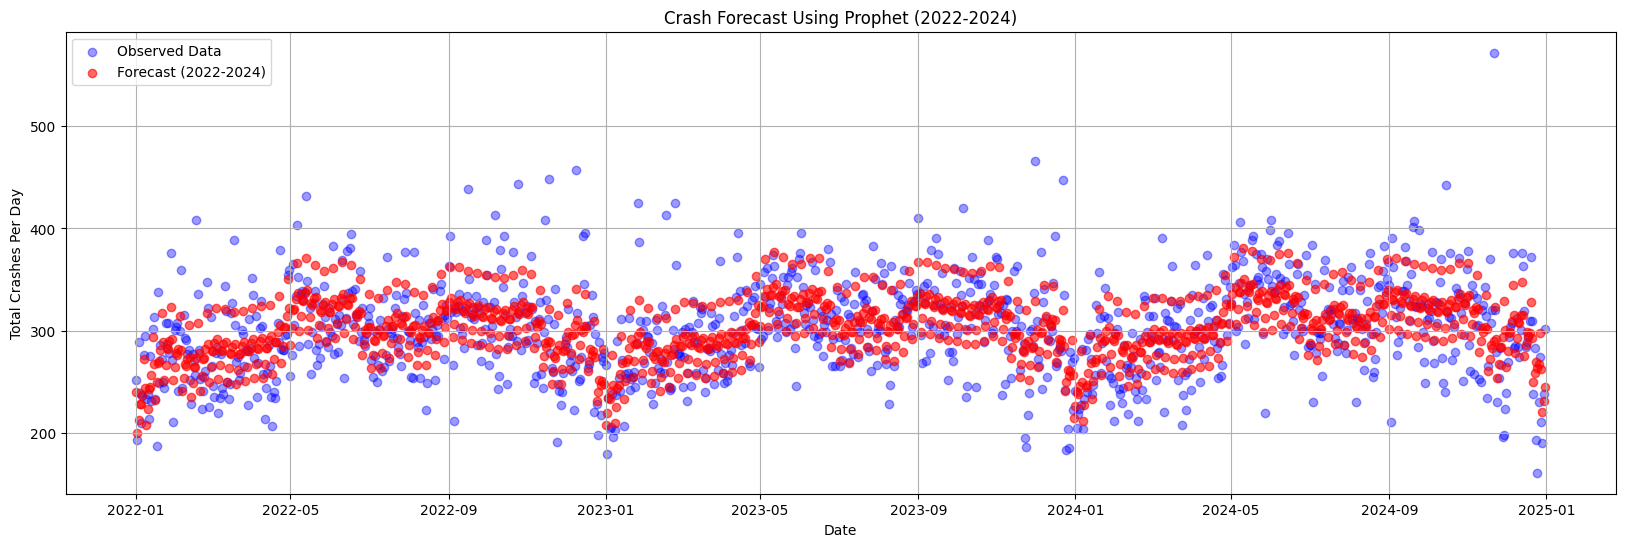

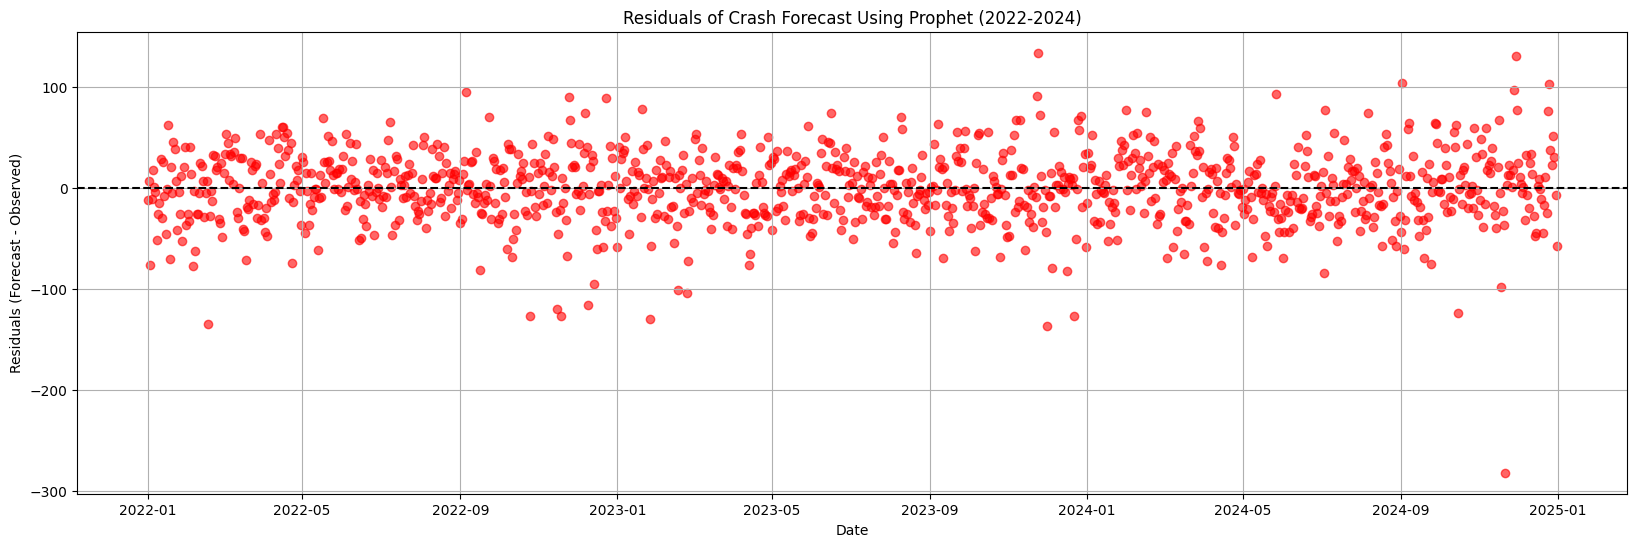

In [28]:
# Create future dataframe only for the training period (NO 2025 FORECAST)
train_only_22_24 = df_prophet_filtered[["ds"]]  # Use only observed dates, no future dates

# Generate forecast only for these dates
forecast_22_24_new_train = model.predict(train_only_22_24)

# Plot observed vs. forecasted crashes for 2022-2024 data

plt.figure(figsize=(20, 6))
plt.scatter(df_prophet_filtered["ds"], df_prophet_filtered["y"], alpha=0.4, color="blue", label="Observed Data")
plt.scatter(forecast_22_24_new_train["ds"], forecast_22_24_new_train["yhat"], color="red", label="Forecast (2022-2024)", alpha=0.6)
plt.xlabel("Date")
plt.ylabel("Total Crashes Per Day")
plt.title("Crash Forecast Using Prophet (2022-2024)")
plt.legend()
plt.grid(True)
plt.show()

# Compute residuals (Forecast - Observed)
residuals = forecast_22_24_new_train["yhat"].values - df_prophet_filtered["y"].values

# Plot residuals scatterplot
plt.figure(figsize=(20, 6))
plt.scatter(forecast_22_24_new_train["ds"], residuals, color="red", alpha=0.6)
plt.axhline(y=0, color="black", linestyle="--")  # Add horizontal line at y=0

# Labels & title
plt.xlabel("Date")
plt.ylabel("Residuals (Forecast - Observed)")
plt.title("Residuals of Crash Forecast Using Prophet (2022-2024)")
plt.grid(True)
plt.show()

The residuals for this 2022-2024 model show no apparent trend or pattern. This shows us that the model is fitting well to all of the different seasonal trends. 

In [29]:
# compute RMSE for 2022-2024 forecast
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = mean_squared_error(df_prophet_filtered["y"], forecast_22_24_new_train["yhat"], squared=False)

print(f"Root Mean Squared Error (RMSE) for 2022-2024 Forecast: {rmse:.2f}")

Root Mean Squared Error (RMSE) for 2022-2024 Forecast: 35.53


c:\Users\chris\Documents\Senior_Project\CT_SeniorProject\.venv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


The RMSE for this 2022-2024 model is 35.53 crashes per day. This is lower than that of the 2018-2024 model, which was 42.38 crashes per day. Since it has a smaller RMSE, we can conlcude that the 2022-2024 model is more accurate in predicting crash rates.

<Figure size 1000x500 with 0 Axes>

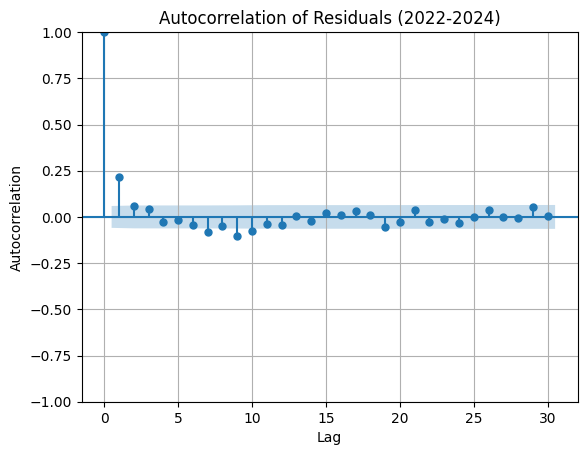

In [30]:
# Run autocorrelation plot on residuals from 2022-2024

# pip install statsmodels
from statsmodels.graphics.tsaplots import plot_acf
residuals = forecast_22_24_new_train["yhat"].values - df_prophet_filtered["y"].values
residuals = pd.Series(residuals).dropna()

# Autocorrelation plot
plt.figure(figsize=(10, 5))
plot_acf(residuals, lags=30)
plt.title("Autocorrelation of Residuals (2022-2024)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.show()

Interpreting the Autocorrelation of Residuals (2022-2024):
This autocorrelation function (ACF) plot tells us how much the residuals (forecast errors) are correlated with themselves at different time lags. In other words, does an error today influence errors tomorrow, next week, or in the future?

Key Components of the Graph
- Lag (x-axis) → The number of days in the past we are comparing residuals to.
- Autocorrelation (y-axis) → Measures how similar past residuals are to current residuals.
- Blue bars → Confidence intervals (if points fall outside these bars, autocorrelation is significant).
- Dots (autocorrelation values) → If a dot is significantly above or below zero, it suggests a pattern that the model did not fully capture.

- The first point at lag 0 is always 1 because residuals are perfectly correlated with themselves.
- Some autocorrelation is present at lag 1, meaning there may be short-term dependencies in crash rates that weren’t fully captured by the model. Today's crash rates seem to impact tomorrow's crash rates.
- There is a small spike at lag 7. This seems to suggest some kind of weekly seasonality, with a 7-day lag. This suggests Prophet did not capture all of the seasonality.
- Most values are within the blue confidence interval, meaning the errors do not show strong patterns. This suggests the model does a good job at capturing trends and seasonality.

# Section 5: Holt Winters Smoothing

### What is Holt-Winters Smoothing?
Holt-Winters is a forecasting technique that smooths a time series using three components:

Level (α - Alpha): The base value of the series.
Trend (β - Beta): The long-term increase or decrease.
Seasonality (γ - Gamma): The repeating pattern (e.g., weekly cycle in crash data).

### Why Use Holt-Winters?

Better at handling seasonality than ARIMA.
Can adapt to changing trends over time.
Works well for short-term forecasts (e.g., weekly patterns).

In [31]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

alphavalue = 0.2

## Apply Holt-Winters Smoothing (weekly seasonality)
hws_model = ExponentialSmoothing(
    df_prophet_filtered["y"],  # Target variable
    trend="add",  # Linear trend
    seasonal="add",  # Additive seasonality
    seasonal_periods=7  # Weekly seasonality
).fit() # adjust smoothing level


print(hws_model.summary())

c:\Users\chris\Documents\Senior_Project\CT_SeniorProject\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                       ExponentialSmoothing Model Results                       
Dep. Variable:                        y   No. Observations:                 1096
Model:             ExponentialSmoothing   SSE                        1580726.303
Optimized:                         True   AIC                           7994.274
Trend:                         Additive   BIC                           8049.268
Seasonal:                      Additive   AICC                          7994.610
Seasonal Periods:                     7   Date:                 Sat, 19 Apr 2025
Box-Cox:                          False   Time:                         23:31:35
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1883608                alpha                 True
smoothing_trend          

In [32]:
# Compute Mean Squared Error (MSE)
mse = np.mean((hws_model.fittedvalues - df_crashes_per_day["Total_Crashes"])**2)
print("Mean Squared Error (Holt-Winters):", mse)
print("Root Mean Squared Error (Holt-Winters):", np.sqrt(mse)) #about 40 crashes RMSE


Mean Squared Error (Holt-Winters): 1442.2685250359473
Root Mean Squared Error (Holt-Winters): 37.977210601042664


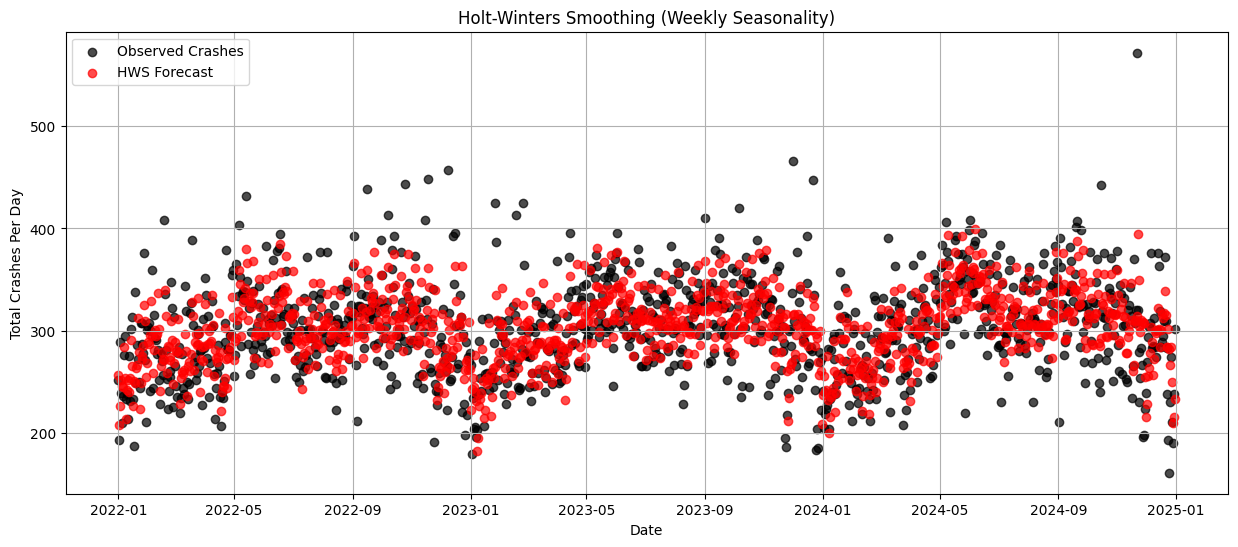

In [60]:
# Generate predictions
df_prophet_filtered["HWS_Forecast"] = hws_model.fittedvalues

# Plot original vs. smoothed values
plt.figure(figsize=(15, 6))
plt.scatter(df_prophet_filtered["ds"], df_prophet_filtered["y"], label="Observed Crashes", alpha=0.7, color="black")
plt.scatter(df_prophet_filtered["ds"], df_prophet_filtered["HWS_Forecast"], label="HWS Forecast", alpha=0.7, color="red")
plt.xlabel("Date")
plt.ylabel("Total Crashes Per Day")
plt.title("Holt-Winters Smoothing (Weekly Seasonality)")
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1000x500 with 0 Axes>

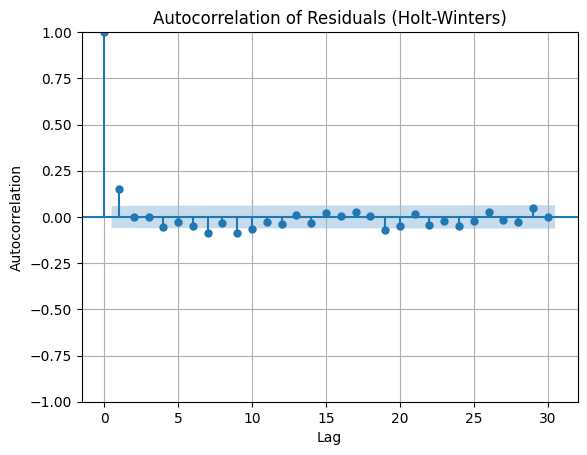

In [34]:
# plot ACF graph of residuals of HWS graph
from statsmodels.graphics.tsaplots import plot_acf

# Compute residuals
residuals = df_prophet_filtered["y"] - df_prophet_filtered["HWS_Forecast"]
residuals = residuals.dropna()

# Plot autocorrelation
plt.figure(figsize=(10, 5))
plot_acf(residuals, lags=30)
plt.title("Autocorrelation of Residuals (Holt-Winters)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.show()

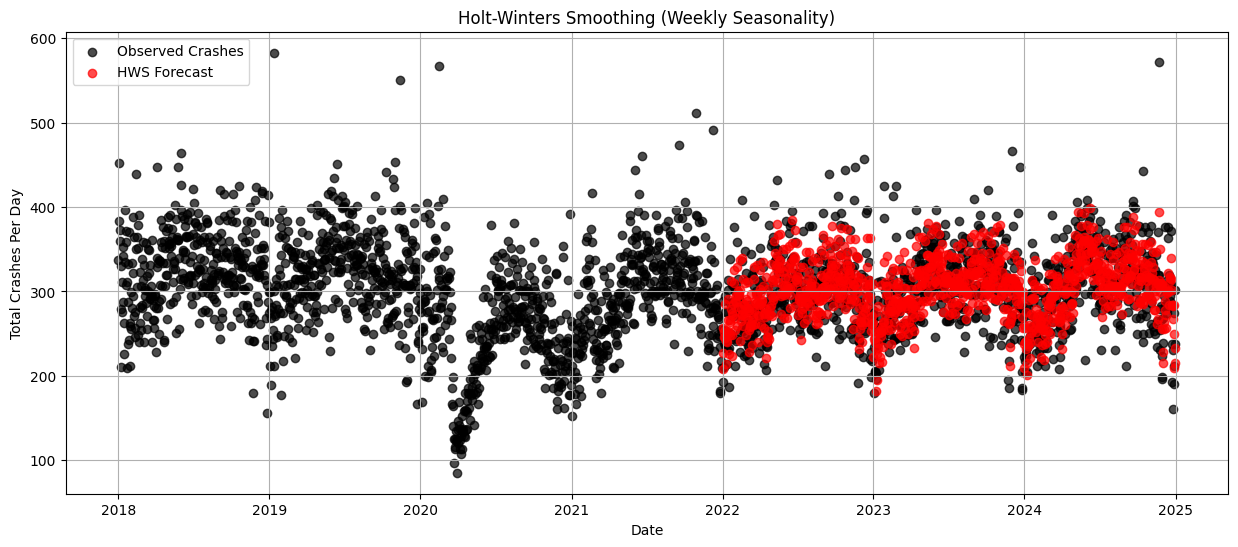

In [35]:
# Generate predictions
df_crashes_per_day["HWS_Forecast"] = hws_model.fittedvalues

# Plot original vs. smoothed values
plt.figure(figsize=(15, 6))
plt.scatter(df_crashes_per_day["CRASH_DATE"], df_crashes_per_day["Total_Crashes"], label="Observed Crashes", alpha=0.7, color="black")
plt.scatter(df_crashes_per_day["CRASH_DATE"], df_crashes_per_day["HWS_Forecast"], label="HWS Forecast", alpha=0.7, color="red")
plt.xlabel("Date")
plt.ylabel("Total Crashes Per Day")
plt.title("Holt-Winters Smoothing (Weekly Seasonality)")
plt.legend()
plt.grid(True)
plt.show()

The HWS prediction line follows the observed data closely. This means that the weekly seasonality is being captured well. 


The smoothing_level (α) controls how fast the model adapts to changes:
- Low values (e.g., 0.1 - 0.3) = Slower adaptation, smoother trend.
- High values (e.g., 0.7 - 1.0) = Faster adaptation, reacts quickly to recent changes.

After playing around with multiple alpha values, the alpha value at 0.2 seems to fit the data well. 

There are two types of HWS models: Additive and Multiplicative. Let's compare the two models to see which better fits this time series data

- Additive (seasonal="add") = Assumes crash fluctuations are consistent in magnitude.
- Multiplicative (seasonal="mul") = Assumes fluctuations grow or shrink over time.

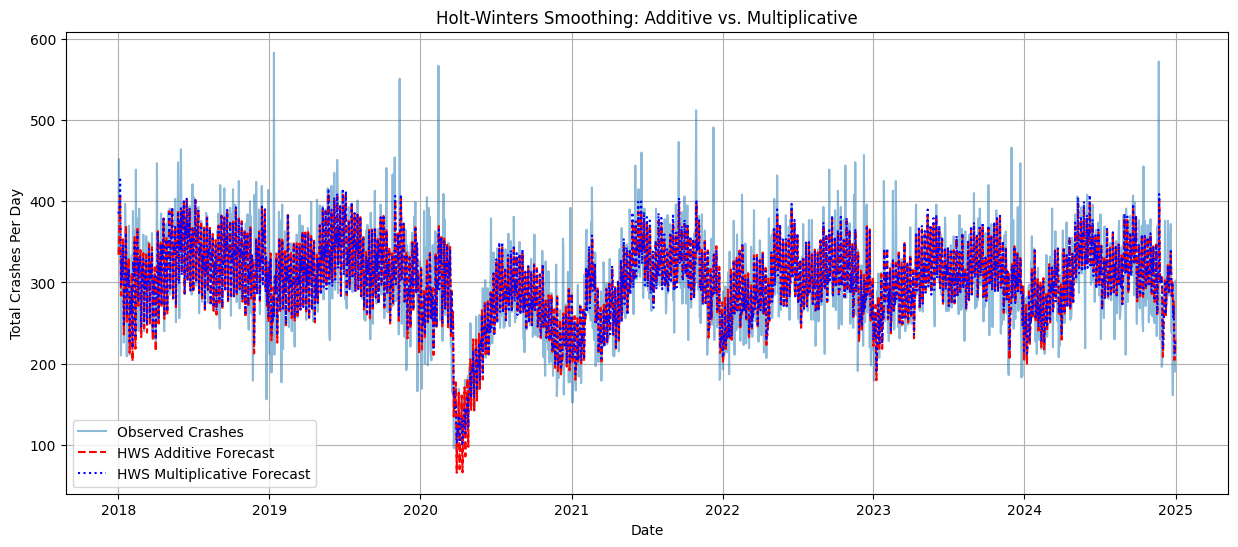

In [36]:
# Additive Holt-Winters Model (weekly seasonality)
hws_add = ExponentialSmoothing(
    df_crashes_per_day["Total_Crashes"],
    trend="add",
    seasonal="add",
    seasonal_periods=7
).fit()

# Multiplicative Holt-Winters Model (weekly seasonality)
hws_mul = ExponentialSmoothing(
    df_crashes_per_day["Total_Crashes"],
    trend="add",
    seasonal="mul",
    seasonal_periods=7
).fit()

# Store results
df_crashes_per_day["HWS_Add_Forecast"] = hws_add.fittedvalues
df_crashes_per_day["HWS_Mul_Forecast"] = hws_mul.fittedvalues

# Plot both models
plt.figure(figsize=(15, 6))
plt.plot(df_crashes_per_day["CRASH_DATE"], df_crashes_per_day["Total_Crashes"], label="Observed Crashes", alpha=0.5)
plt.plot(df_crashes_per_day["CRASH_DATE"], df_crashes_per_day["HWS_Add_Forecast"], label="HWS Additive Forecast", color="red", linestyle="dashed")
plt.plot(df_crashes_per_day["CRASH_DATE"], df_crashes_per_day["HWS_Mul_Forecast"], label="HWS Multiplicative Forecast", color="blue", linestyle="dotted")
plt.xlabel("Date")
plt.ylabel("Total Crashes Per Day")
plt.title("Holt-Winters Smoothing: Additive vs. Multiplicative")
plt.legend()
plt.grid(True)
plt.show()


The above graph compares the Holt-Winters Smoothing with Additive and Multiplicative Seasonality:

1. Both models capture the seasoanlity well
- Both the red and blue line follow the weekly fluctuations well -> this suggests weekly seasonality is strong 

2. The multiplicative odel (blue) is more "conservative" in certain areas
- We can see this in 2020 with the COVID dip
- Also can see this in early 2018, early 2019, early 2023, and early 2024. 
- The multiplicative model does not react as strongly as the additive model

Why does the multiplicative not react as strongly?
- Multiplicative seasonality scales proportionally, meaning it shrinks fluctuations when crash counts are lower (2020) and expands them when counts are higher (2023).
- The additive model (red) fluctuates more aggressively, assuming fixed seasonal patterns regardless of the overall trend.


Multiplicative model might be better for long-term stability:
- Since the amplitude of seasonal fluctuations changes over time, the multiplicative model might be better at capturing long-term trends.
- However, if the seasonality is truly constant over time, then the additive model is better.


We should note that both models struggle slightly with extreme spikes. Sharp peaks (early 2019, late 2024) are not fully captured by either model. This could suggest that daily crash data has unpredictable spikes (possibly from weather, holidays, or traffic events).


In [37]:
# Compare the two Holt-Winters models (additive and multiplicative) using MAE and RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Compute MAE & RMSE for the full dataset (2018-2024)
mae_add = mean_absolute_error(df_crashes_per_day["Total_Crashes"], df_crashes_per_day["HWS_Add_Forecast"])
rmse_add = np.sqrt(mean_squared_error(df_crashes_per_day["Total_Crashes"], df_crashes_per_day["HWS_Add_Forecast"]))

mae_mul = mean_absolute_error(df_crashes_per_day["Total_Crashes"], df_crashes_per_day["HWS_Mul_Forecast"])
rmse_mul = np.sqrt(mean_squared_error(df_crashes_per_day["Total_Crashes"], df_crashes_per_day["HWS_Mul_Forecast"]))

# Compute errors for 2022-2024
df_2022_2024 = df_crashes_per_day[(df_crashes_per_day["CRASH_DATE"] >= "2022-01-01") & 
                                  (df_crashes_per_day["CRASH_DATE"] <= "2024-12-31")]

mae_add_22_24 = mean_absolute_error(df_2022_2024["Total_Crashes"], df_2022_2024["HWS_Add_Forecast"])
rmse_add_22_24 = np.sqrt(mean_squared_error(df_2022_2024["Total_Crashes"], df_2022_2024["HWS_Add_Forecast"]))

mae_mul_22_24 = mean_absolute_error(df_2022_2024["Total_Crashes"], df_2022_2024["HWS_Mul_Forecast"])
rmse_mul_22_24 = np.sqrt(mean_squared_error(df_2022_2024["Total_Crashes"], df_2022_2024["HWS_Mul_Forecast"]))

# Create a DataFrame to store the results
error_metrics = pd.DataFrame({
    "Model": ["HWS Additive", "HWS Multiplicative"],
    "MAE (2018-2024)": [mae_add, mae_mul],
    "RMSE (2018-2024)": [rmse_add, rmse_mul],
    "MAE (2022-2024)": [mae_add_22_24, mae_mul_22_24],
    "RMSE (2022-2024)": [rmse_add_22_24, rmse_mul_22_24]
})

# Display the results
print(error_metrics)

                Model  MAE (2018-2024)  RMSE (2018-2024)  MAE (2022-2024)  \
0        HWS Additive        29.085822         39.688424        28.760243   
1  HWS Multiplicative        29.016884         39.551900        28.597127   

   RMSE (2022-2024)  
0         38.147641  
1         38.019450  


### Holt Winters vs Prophet forecast 
Let's compare the Holt-Winters forecast to the Prophet forecast. Which is better?

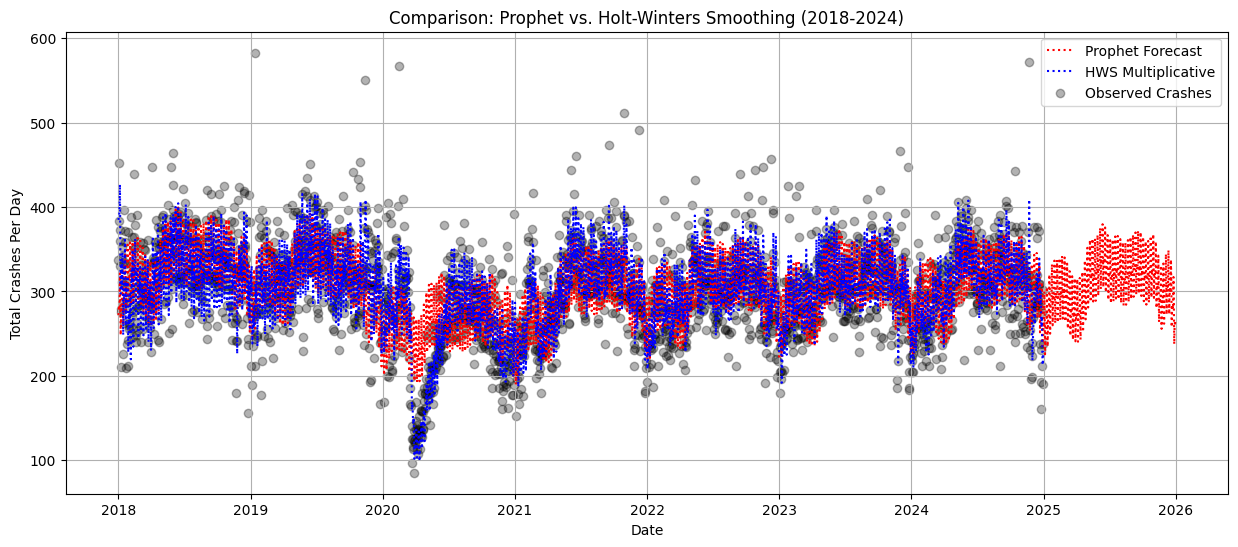

In [38]:
# Plot Prophet Forecast vs. Holt-Winters
plt.figure(figsize=(15, 6))

# Prophet Forecast (Includes all years 2018-2024)
plt.plot(forecast["ds"], forecast["yhat"], label="Prophet Forecast", color="red", linestyle="dotted")

# Holt-Winters Forecast (Multiplicative Model)
plt.plot(df_crashes_per_day["CRASH_DATE"], df_crashes_per_day["HWS_Mul_Forecast"], label="HWS Multiplicative", color="blue", linestyle="dotted")

# Observed Data
plt.scatter(df_crashes_per_day["CRASH_DATE"], df_crashes_per_day["Total_Crashes"], alpha=0.3, label="Observed Crashes", color="black")

plt.xlabel("Date")
plt.ylabel("Total Crashes Per Day")
plt.title("Comparison: Prophet vs. Holt-Winters Smoothing (2018-2024)")
plt.legend()
plt.grid(True)
plt.show()



In [39]:
# Fit an ARIMAX model to the residuals
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAXResults


# Define the ARIMAX model
model = SARIMAX(residuals, order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))

# Fit the model
model_fit = model.fit()

# Display model summary
print(model_fit.summary())


c:\Users\chris\Documents\Senior_Project\CT_SeniorProject\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\chris\Documents\Senior_Project\CT_SeniorProject\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1096
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -5523.539
Date:                           Sat, 19 Apr 2025   AIC                          11057.077
Time:                                   23:31:41   BIC                          11082.074
Sample:                                        0   HQIC                         11066.536
                                          - 1096                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1265      0.188     -0.674      0.500      -0.494       0.241
ma.L1          0.2792      0.184      1.516

# Section 5 - SARIMAX Weather Forecasting 

In [40]:
df_ord = pd.read_csv("C:/Users/chris/Documents/Senior_Project/CT_SeniorProject/CrashData_Repo1/data/external/ORD_Weather.csv")
df_mdw = pd.read_csv("C:/Users/chris/Documents/Senior_Project/CT_SeniorProject/CrashData_Repo1/data/external/Midway_Weather.csv")

In [41]:
#### Data Cleaning ####

rename_ord_dict = {
    "DATE": "CRASH_DATE",
    "AWND": "Avg_Wind_Speed_ORD",
    "PRCP": "Precipitation_ORD",
    "SNOW": "Snowfall_ORD",
    "SNWD": "Snow_Depth_ORD",
    "TAVG": "Avg_Temperature_ORD",
    "TMAX": "Max_Temperature_ORD",
    "TMIN": "Min_Temperature_ORD",
    "WT01": "Fog_ORD",
    "WT02": "Heavy_Fog_ORD",
    "WT03": "Thunder_ORD",
    "WT04": "Ice_Pellets_ORD",
    "WT05": "Hail_ORD",
    "WT06": "Glaze_Ice_ORD",
    "WT08": "Smoke_ORD",
    "WT09": "Blowing_Snow_ORD",
}
rename_mdw_dict = {
    "DATE": "CRASH_DATE",
    "AWND": "Avg_Wind_Speed_MDW",
    "PRCP": "Precipitation_MDW",
    "SNOW": "Snowfall_MDW",
    "SNWD": "Snow_Depth_MDW",
    "TAVG": "Avg_Temperature_MDW",
    "TMAX": "Max_Temperature_MDW",
    "TMIN": "Min_Temperature_MDW",
    "WT01": "Fog_MDW",
    "WT02": "Heavy_Fog_MDW",
    "WT03": "Thunder_MDW",
    "WT04": "Ice_Pellets_MDW",
    "WT05": "Hail_MDW",
    "WT06": "Glaze_Ice_MDW",
    "WT08": "Smoke_MDW",
    "WT09": "Blowing_Snow_MDW",
}

# Apply renaming to the dataframe
df_ord = df_ord.rename(columns=rename_ord_dict)
df_mdw = df_mdw.rename(columns=rename_mdw_dict)


# 1. Get rid of the unnecessary columns
ord_keep_cols = [
    "CRASH_DATE",
    "Avg_Wind_Speed_ORD",
    "Precipitation_ORD",
    "Snowfall_ORD",
    "Snow_Depth_ORD",
    "Avg_Temperature_ORD",
    "Max_Temperature_ORD",
    "Min_Temperature_ORD",
    "Fog_ORD",
    "Heavy_Fog_ORD",
    "Thunder_ORD",
    "Ice_Pellets_ORD",
    "Hail_ORD",
    "Glaze_Ice_ORD",
    "Smoke_ORD",
    "Blowing_Snow_ORD"
]
mdw_keep_cols = [
    "CRASH_DATE",
    "Avg_Wind_Speed_MDW",
    "Precipitation_MDW",
    "Snowfall_MDW",
    "Snow_Depth_MDW",
    "Avg_Temperature_MDW",
    "Max_Temperature_MDW",
    "Min_Temperature_MDW",
    "Fog_MDW",
    "Heavy_Fog_MDW",
    "Thunder_MDW",
    "Ice_Pellets_MDW",
    "Hail_MDW",
    "Glaze_Ice_MDW",
    "Smoke_MDW",
    "Blowing_Snow_MDW"
]

# Filter only the above columns (so there are no unnecessary columns)
df_ord_filtered = df_ord[ord_keep_cols]
df_mdw_filtered = df_mdw[mdw_keep_cols]

# 2. Fill in any missing values

# check to see if there are any missing values
print(df_ord_filtered.isnull().sum())
print(df_mdw_filtered.isnull().sum())


# check unqiue values for each column to see what we need to fill in
weather_event_columns_ord = ["Fog_ORD", "Heavy_Fog_ORD", "Thunder_ORD", "Ice_Pellets_ORD", "Hail_ORD", "Glaze_Ice_ORD", "Smoke_ORD", "Blowing_Snow_ORD"]
weather_event_columns_mdw = ["Fog_MDW", "Heavy_Fog_MDW", "Thunder_MDW", "Ice_Pellets_MDW", "Hail_MDW", "Glaze_Ice_MDW", "Smoke_MDW", "Blowing_Snow_MDW"]

for col in weather_event_columns_ord:
    print(f"{col}: {df_ord_filtered[col].unique()}")
    # results: these are all binary flags, either 1 or NaN

    # Handle missing values

## fix df_ord_filtered
df_ord_filtered["Snow_Depth_ORD"].fillna(0, inplace=True) # One missing snow value... assume 0 snowfall
df_ord_filtered["Avg_Wind_Speed_ORD"].fillna(0, inplace=True) # One missing windspeed value... assume 0 wind

# fix binary weather event columns
for col in weather_event_columns_ord:
    df_ord_filtered[col].fillna(0, inplace=True)

# fix df_mdw_filtered
df_mdw_filtered["Avg_Wind_Speed_MDW"].fillna(0, inplace=True) # One missing snow value... assume 0 wind
df_mdw_filtered["Precipitation_MDW"].fillna(0, inplace=True) # One missing snow value... assume 0 precipitation
df_mdw_filtered["Snowfall_MDW"].fillna(0, inplace=True) # One missing snow value... assume 0 snowfall
df_mdw_filtered["Snow_Depth_MDW"].fillna(0, inplace=True) # One missing snow value... assume 0 snowfall

# calculate average temperature values (all values are missing currently)
df_mdw_filtered["Avg_Temperature_MDW"] = (df_ord_filtered["Max_Temperature_ORD"] + df_ord_filtered["Min_Temperature_ORD"]) / 2

# fix binary weather event columns
for col in weather_event_columns_mdw:
    df_mdw_filtered[col].fillna(0, inplace=True)



CRASH_DATE                0
Avg_Wind_Speed_ORD        1
Precipitation_ORD         0
Snowfall_ORD              0
Snow_Depth_ORD            1
Avg_Temperature_ORD       0
Max_Temperature_ORD       0
Min_Temperature_ORD       0
Fog_ORD                1550
Heavy_Fog_ORD          2492
Thunder_ORD            2235
Ice_Pellets_ORD        2522
Hail_ORD               2535
Glaze_Ice_ORD          2516
Smoke_ORD              2120
Blowing_Snow_ORD       2529
dtype: int64
CRASH_DATE                0
Avg_Wind_Speed_MDW        1
Precipitation_MDW         4
Snowfall_MDW           2350
Snow_Depth_MDW         1963
Avg_Temperature_MDW    2557
Max_Temperature_MDW       0
Min_Temperature_MDW       0
Fog_MDW                1864
Heavy_Fog_MDW          2531
Thunder_MDW            2318
Ice_Pellets_MDW        2535
Hail_MDW               2552
Glaze_Ice_MDW          2542
Smoke_MDW              2343
Blowing_Snow_MDW       2545
dtype: int64
Fog_ORD: [nan  1.]
Heavy_Fog_ORD: [nan  1.]
Thunder_ORD: [nan  1.]
Ice_Pellets

C:\Users\chris\AppData\Local\Temp\ipykernel_10316\2599877988.py:105: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ord_filtered["Snow_Depth_ORD"].fillna(0, inplace=True) # One missing snow value... assume 0 snowfall
C:\Users\chris\AppData\Local\Temp\ipykernel_10316\2599877988.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ord_filt

In [42]:
print(df_ord_filtered.isnull().sum()) #check that the important variables are not missing
print(df_mdw_filtered.isnull().sum()) #check that the important variables are not missing

CRASH_DATE             0
Avg_Wind_Speed_ORD     0
Precipitation_ORD      0
Snowfall_ORD           0
Snow_Depth_ORD         0
Avg_Temperature_ORD    0
Max_Temperature_ORD    0
Min_Temperature_ORD    0
Fog_ORD                0
Heavy_Fog_ORD          0
Thunder_ORD            0
Ice_Pellets_ORD        0
Hail_ORD               0
Glaze_Ice_ORD          0
Smoke_ORD              0
Blowing_Snow_ORD       0
dtype: int64
CRASH_DATE             0
Avg_Wind_Speed_MDW     0
Precipitation_MDW      0
Snowfall_MDW           0
Snow_Depth_MDW         0
Avg_Temperature_MDW    0
Max_Temperature_MDW    0
Min_Temperature_MDW    0
Fog_MDW                0
Heavy_Fog_MDW          0
Thunder_MDW            0
Ice_Pellets_MDW        0
Hail_MDW               0
Glaze_Ice_MDW          0
Smoke_MDW              0
Blowing_Snow_MDW       0
dtype: int64


In [43]:
# 2. Merge the two dataframes on the CRASH_DATE column
df_weather_merged = pd.merge(df_ord_filtered, df_mdw_filtered, on="CRASH_DATE", how="inner")

# Ensure CRASH_DATE is in datetime format (if not already)
df['CRASH_DATE'] = pd.to_datetime(df['CRASH_DATE'])

# Aggregate total crashes per day
df_crashes_per_day = df.groupby("CRASH_DATE").size().reset_index(name="Total_Crashes")

# Display the first few rows
print(df_crashes_per_day.head())

df_weather_merged["CRASH_DATE"] = pd.to_datetime(df_weather_merged["CRASH_DATE"])

# Merge crash data with weather data
df_merged = pd.merge(df_crashes_per_day, df_weather_merged, on="CRASH_DATE", how="left")

# Verify the merged dataset
df_merged.head()

  CRASH_DATE  Total_Crashes
0 2018-01-01            337
1 2018-01-02            452
2 2018-01-03            383
3 2018-01-04            360
4 2018-01-05            373


CRASH_DATE  Total_Crashes  Avg_Wind_Speed_ORD  Precipitation_ORD  \
0 2018-01-01            337               10.74                0.0   
1 2018-01-02            452               11.18                0.0   
2 2018-01-03            383               12.30                0.0   
3 2018-01-04            360               12.30                0.0   
4 2018-01-05            373               10.74                0.0   

   Snowfall_ORD  Snow_Depth_ORD  Avg_Temperature_ORD  Max_Temperature_ORD  \
0           0.0             1.2                   -2                    1   
1           0.0             1.2                   -2                    8   
2           0.1             1.2                   11                   17   
3           0.0             1.2                    7                   12   
4           0.0             1.2                    5                   11   

   Min_Temperature_ORD  Fog_ORD  ...  Max_Temperature_MDW  \
0                   -9      0.0  ...                    3   
1                   -9      0.0  ...                    7   
2                    6      1.0  ...                   18   
3                    0      0.0  ...                   13   
4                   -1      0.0  ...                   12   

   Min_Temperature_MDW  Fog_MDW  Heavy_Fog_MDW  Thunder_MDW  Ice_Pellets_MDW  \
0                   -7      0.0            0.0          0.0              0.0   
1                  -10      0.0            0.0          0.0              0.0   
2                    7      0.0            0.0          0.0              0.0   
3                    2      0.0            0.0          0.0              0.0   
4                    0      0.0            0.0          0.0              0.0   

   Hail_MDW  Glaze_Ice_MDW  Smoke_MDW  Blowing_Snow_MDW  
0       0.0            0.0        0.0               0.0  
1       0.0            0.0        0.0               0.0  
2       0.0            0.0        0.0               0.0  
3       0.0            0.0        0.0               0.0  
4       0.0            0.0        0.0               0.0  

[5 rows x 32 columns]

Merge the two datasets (df_crashes_per_day and df_weather_merged) based on date. 

Why are we doing this on crashes per day and not indidivual crashes?
- weather applies to the entire day, not just each individ crash
- time series works ebst with aggregated data
- simplify the dataset

23:31:42 - cmdstanpy - INFO - Chain [1] start processing
23:31:42 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\chris\AppData\Local\Temp\ipykernel_10316\2932307433.py:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future["Precipitation_ORD"] = future["Precipitation_ORD"].fillna(method="ffill")


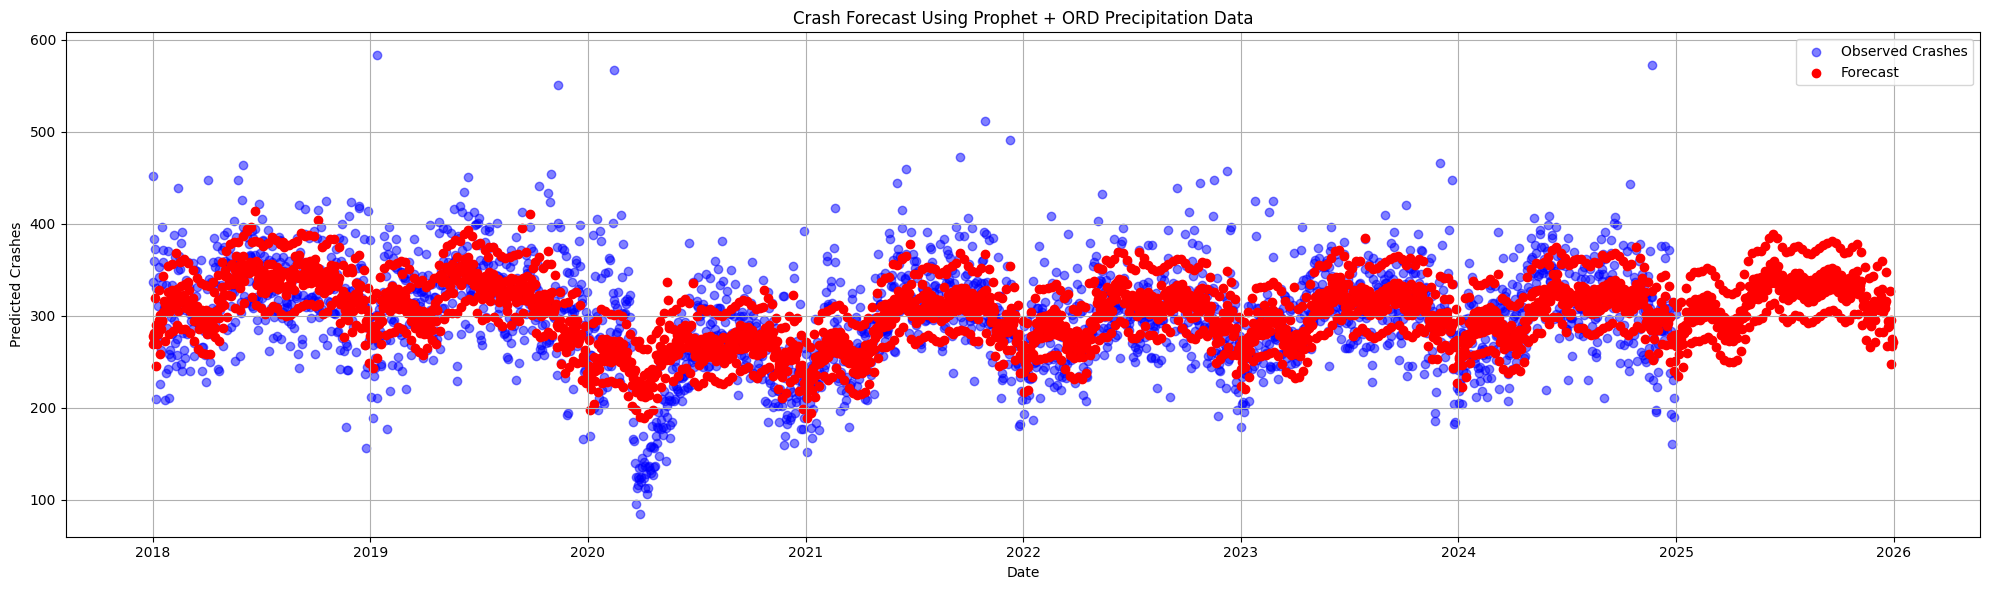

In [44]:
from prophet import Prophet
import matplotlib.pyplot as plt

# STEP 1: Prepare the dataframe
# Prophet requires columns named 'ds' (date) and 'y' (target)
df_merged["CRASH_DATE"] = pd.to_datetime(df_merged["CRASH_DATE"])
df_prophet = df_merged.reset_index()[["Total_Crashes", "Precipitation_ORD"]].copy()
df_prophet["ds"] = df_merged["CRASH_DATE"] # set CRASH_DATE as 'ds'
df_prophet["y"] = df_prophet["Total_Crashes"]

# STEP 2: Initialize the model and add weather regressors
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

model.add_regressor("Precipitation_ORD")

# STEP 2: Fit the model
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
model.fit(df_prophet)

# STEP 3: Create future dataframe
future = model.make_future_dataframe(periods=365)  # forecast 1 year 

# STEP 4: Add weather regressors to the future dataframe
# NOTE: You must supply values for the regressors even in the future period

# Merge past weather data
future = pd.merge(future, df_prophet[["ds", "Precipitation_ORD"]], on="ds", how="left")

# You can fill future values manually or interpolate (for now, we'll forward fill)
future["Precipitation_ORD"] = future["Precipitation_ORD"].fillna(method="ffill")

# STEP 5: Forecast
forecast = model.predict(future)

# STEP 6: Plot forecast
plt.figure(figsize=(20, 6))
plt.scatter(df_prophet["ds"], df_prophet["y"], label="Observed Crashes", alpha=0.5, color="blue")
plt.scatter(forecast["ds"], forecast["yhat"], label="Forecast", color="red")
plt.xlabel("Date")
plt.ylabel("Predicted Crashes")
plt.title("Crash Forecast Using Prophet + ORD Precipitation Data")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


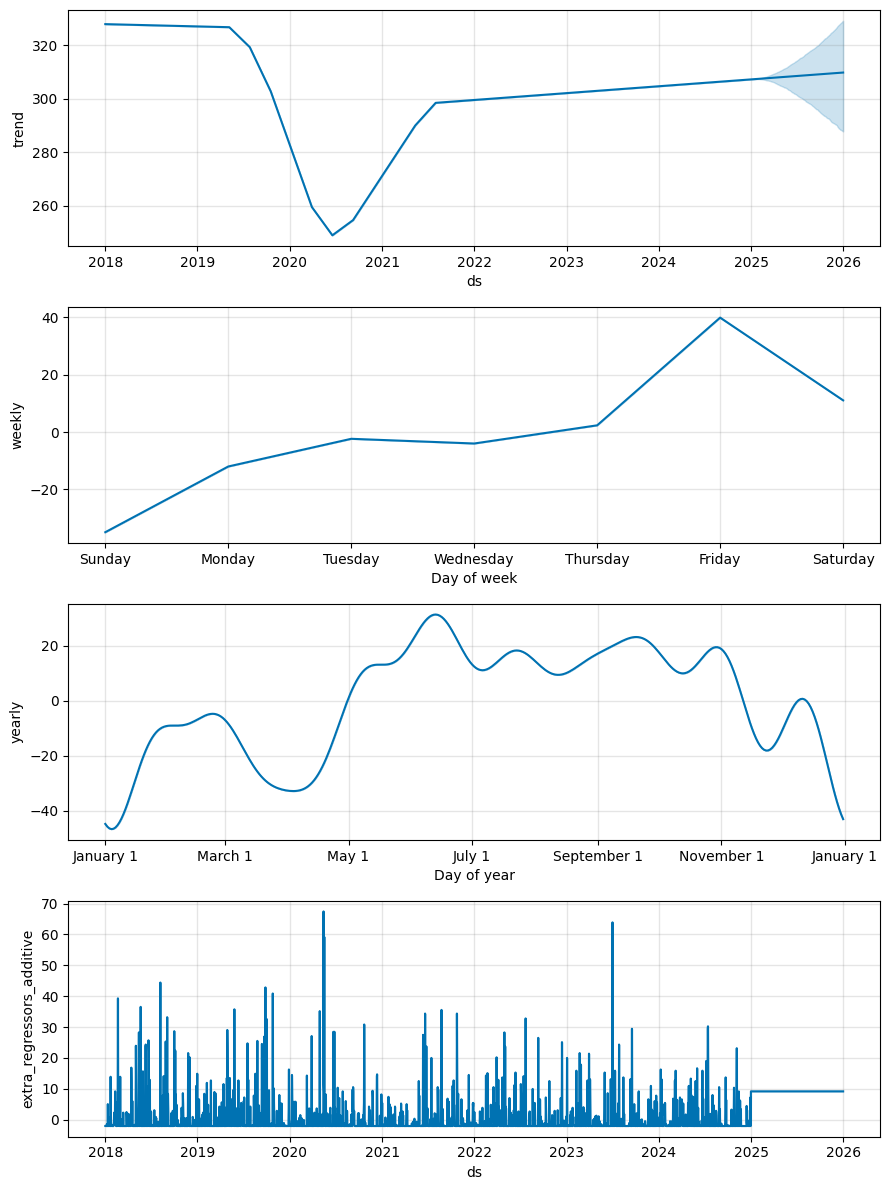

RMSE: 41.96605599225603


In [45]:
# STEP 7:Forecast Components
model.plot_components(forecast)
plt.tight_layout()
plt.show()

# STEP 8: Evaluate the model
# Calculate RMSE
y_true = df_prophet["y"]
y_pred = forecast["yhat"][:len(y_true)]
rmse = sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE: {rmse}")

23:31:46 - cmdstanpy - INFO - Chain [1] start processing
23:31:46 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\chris\AppData\Local\Temp\ipykernel_10316\772521797.py:31: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future["Precipitation_MDW"] = future["Precipitation_MDW"].fillna(method="ffill")


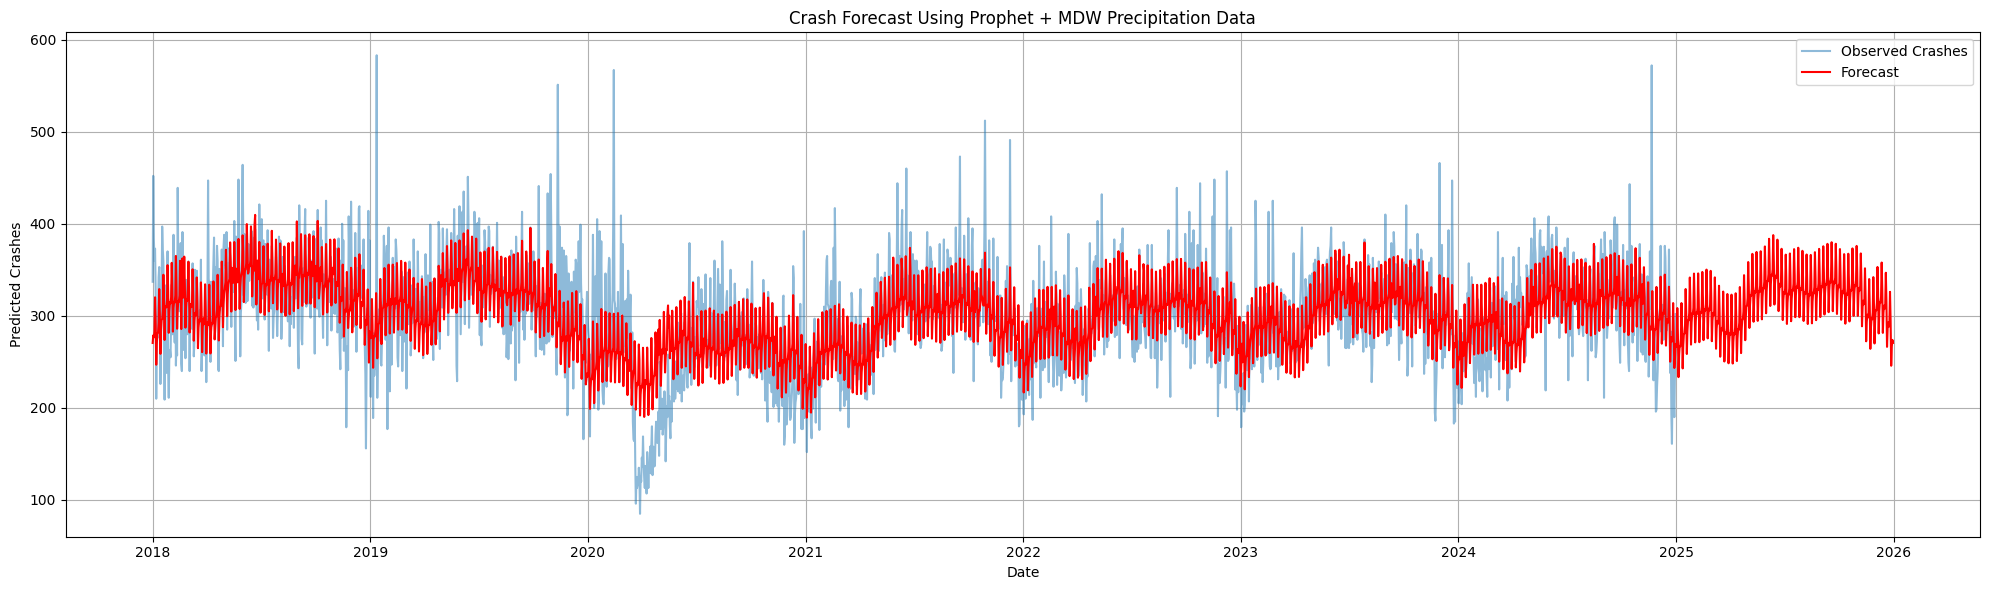

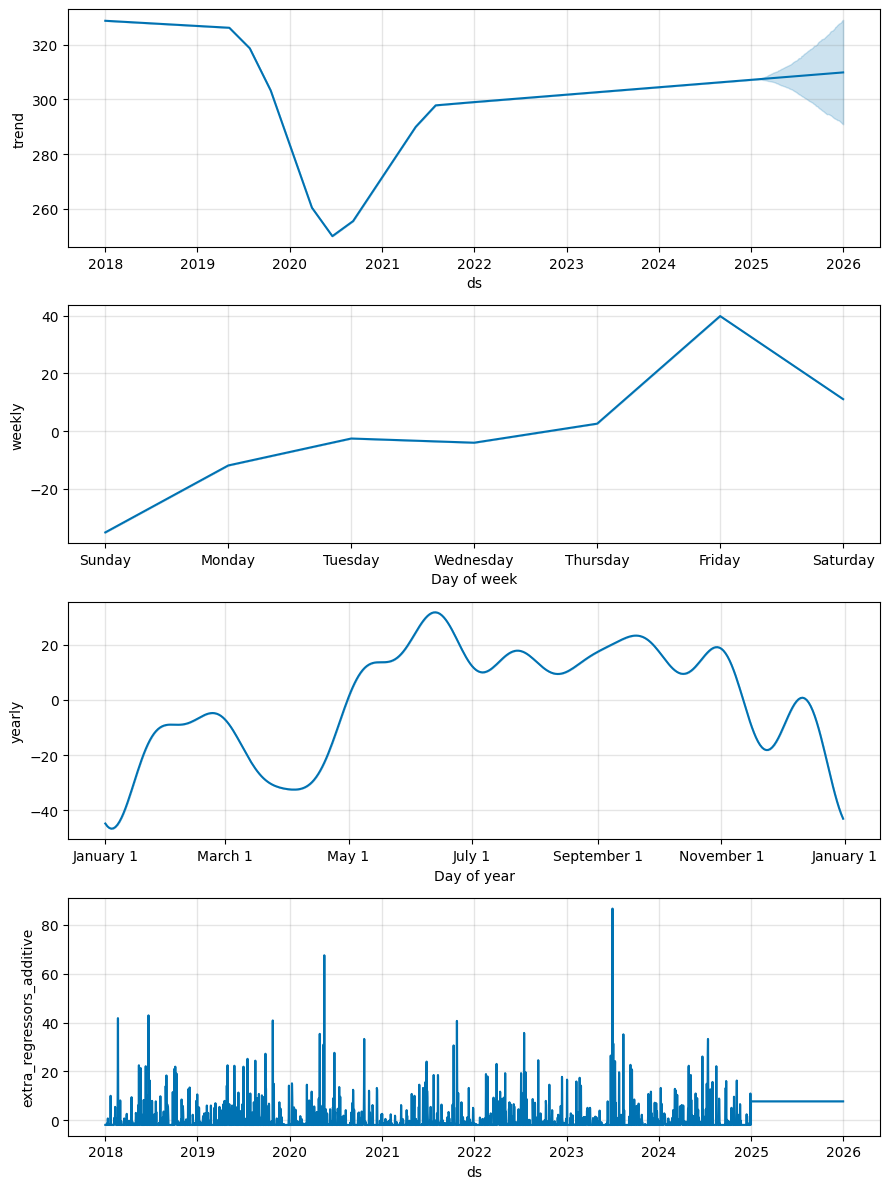

RMSE: 42.04963700253742


In [46]:
# STEP 1: Prepare the dataframe
# Prophet requires columns named 'ds' (date) and 'y' (target)
df_merged["CRASH_DATE"] = pd.to_datetime(df_merged["CRASH_DATE"])
df_prophet = df_merged.reset_index()[["Total_Crashes", "Precipitation_MDW"]].copy()
df_prophet["ds"] = df_merged["CRASH_DATE"] # set CRASH_DATE as 'ds'
df_prophet["y"] = df_prophet["Total_Crashes"]

# STEP 2: Initialize the model and add weather regressors
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

model.add_regressor("Precipitation_MDW") 

# STEP 2: Fit the model
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
model.fit(df_prophet)

# STEP 3: Create future dataframe
future = model.make_future_dataframe(periods=365)  # forecast 1 year 

# STEP 4: Add weather regressors to the future dataframe
# NOTE: You must supply values for the regressors even in the future period

# Merge past weather data
future = pd.merge(future, df_prophet[["ds", "Precipitation_MDW"]], on="ds", how="left")

# You can fill future values manually or interpolate (for now, we'll forward fill)
future["Precipitation_MDW"] = future["Precipitation_MDW"].fillna(method="ffill")

# STEP 5: Forecast
forecast = model.predict(future)

# STEP 6: Plot forecast
plt.figure(figsize=(20, 6))
plt.plot(df_prophet["ds"], df_prophet["y"], label="Observed Crashes", alpha=0.5)
plt.plot(forecast["ds"], forecast["yhat"], label="Forecast", color="red")
plt.xlabel("Date")
plt.ylabel("Predicted Crashes")
plt.title("Crash Forecast Using Prophet + MDW Precipitation Data")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# STEP 7:Forecast Components
model.plot_components(forecast)
plt.tight_layout()
plt.show()

# STEP 8: Evaluate the model
# Calculate RMSE
y_true = df_prophet["y"]
y_pred = forecast["yhat"][:len(y_true)]
rmse = sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE: {rmse}")

Comparing the two RMSE values:
- ORD: 41.96606
- MDW: 42.04964

ORD is barely smaller. The precipitation values are likely extremely similar between the two airports. 

c:\Users\chris\Documents\Senior_Project\CT_SeniorProject\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\chris\Documents\Senior_Project\CT_SeniorProject\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\chris\Documents\Senior_Project\CT_SeniorProject\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


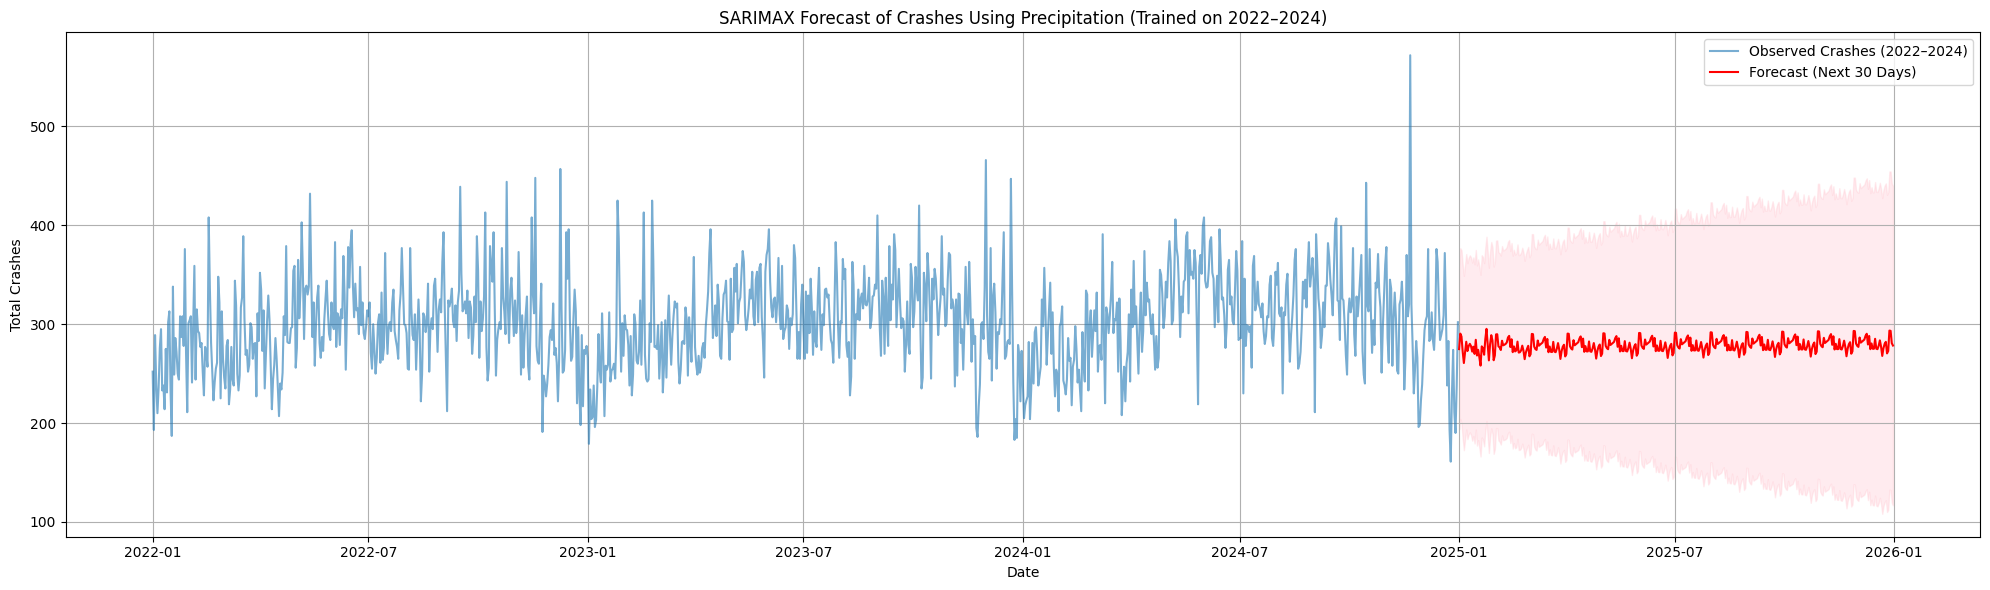

In [47]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- Filter and prepare data ---
df_train_SARIMAX_22_24 = df_merged[(df_merged['CRASH_DATE'] >= '2022-01-01') & (df_merged['CRASH_DATE'] <= '2024-12-31')].copy()
df_train_SARIMAX_22_24['CRASH_DATE'] = pd.to_datetime(df_train_SARIMAX_22_24['CRASH_DATE'])
df_train_SARIMAX_22_24.set_index('CRASH_DATE', inplace=True)

endog = df_train_SARIMAX_22_24['Total_Crashes']
exog = df_train_SARIMAX_22_24[['Precipitation_ORD']]

# --- Fit SARIMAX Model ---
model = SARIMAX(endog, exog=exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 30))
results = model.fit(disp=False)

# Forecast
forecast_steps = 365
future_dates = pd.date_range(start=df_train_SARIMAX_22_24.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)
future_exog = pd.DataFrame({'Precipitation_ORD': [exog['Precipitation_ORD'].mean()] * forecast_steps}, index=future_dates)

forecast = results.get_forecast(steps=forecast_steps, exog=future_exog)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# --- Ensure clean types ---
forecast_ci = forecast_ci.astype(float)
forecast_ci.index = pd.to_datetime(forecast_ci.index)
forecast_mean = forecast_mean.astype(float)

# --- Plot ---
plt.figure(figsize=(20, 6))
plt.plot(endog.index, endog, label='Observed Crashes (2022–2024)', alpha=0.6)
plt.plot(forecast_mean.index, forecast_mean, label='Forecast (Next 30 Days)', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Total Crashes')
plt.title('SARIMAX Forecast of Crashes Using Precipitation (Trained on 2022–2024)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The red forecast line in the above SARIMAX model looks way too flat and lacks the kind of seasonal variation we’d expect based on previous trends. Why is that happening? 

-  I'm passing a constant average precipitation value (exog.mean()) for every day in the future:
    - future_exog = pd.DataFrame({'Precipitation_ORD': [exog['Precipitation_ORD'].mean()] * forecast_steps}, index=future_dates)

By doing this, I'm telling the model "Assume weather will be the same every day/month in the future."

So even though the SARIMAX model was trained with seasonality, it no longer has the seasonal fluctuation from the weather variable to drive those effects in the forecast.

How can we fix this?

- Use Actual or Simulated Future Weather Data (simulate by repeating last year's pattern)
- Model seasonality in the Endogenous variable instead (use SARIMA instead of SARIMAX)

c:\Users\chris\Documents\Senior_Project\CT_SeniorProject\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\chris\Documents\Senior_Project\CT_SeniorProject\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\chris\Documents\Senior_Project\CT_SeniorProject\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


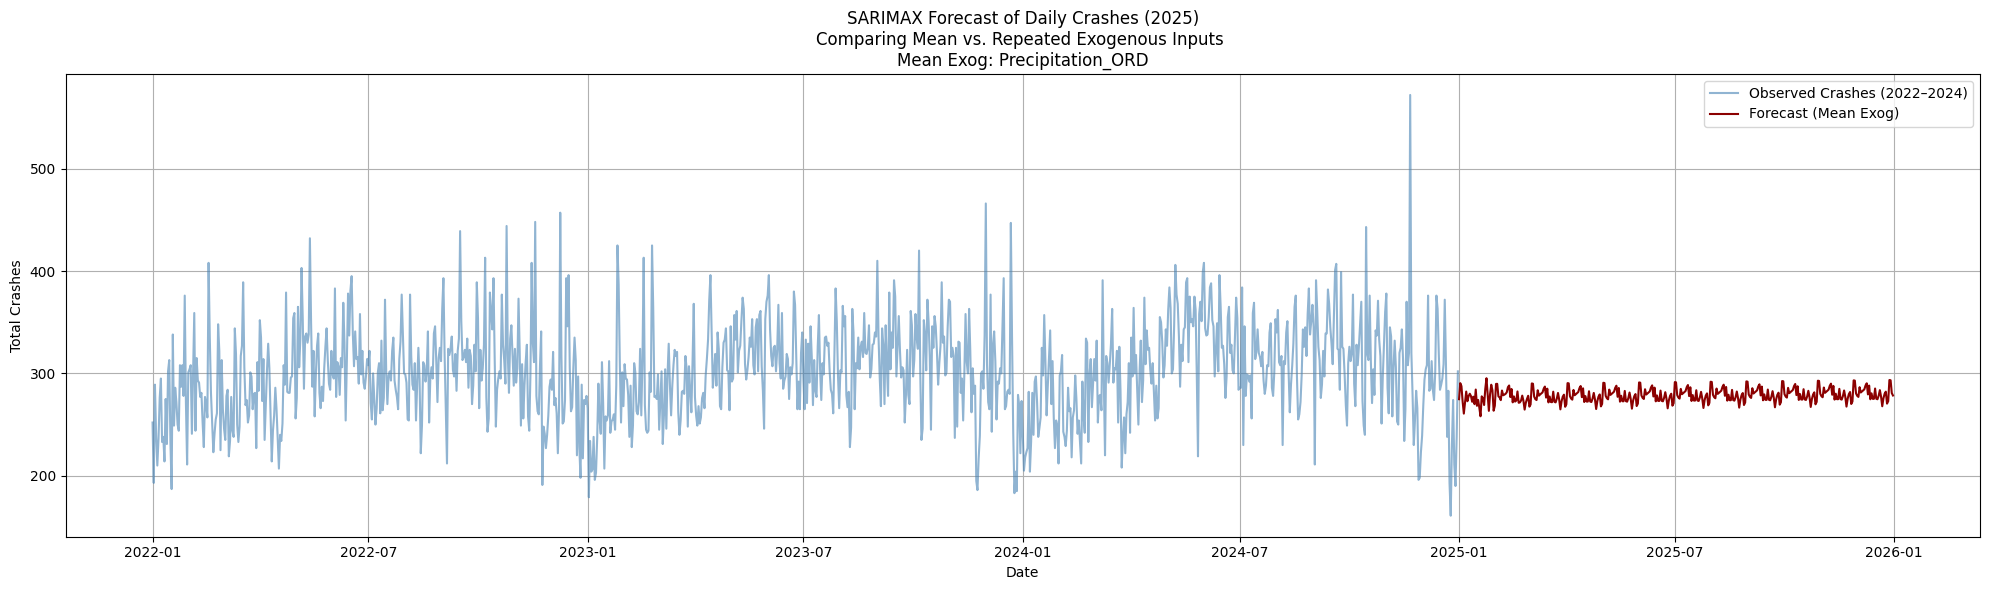

In [48]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define endog (target variable) and exog (external variables)
endog = df_train_SARIMAX_22_24["Total_Crashes"]
exog = df_train_SARIMAX_22_24[["Precipitation_ORD"]]

# Option 1: Use mean value of future exog
forecast_steps = 365
future_dates = pd.date_range(start=df_train_SARIMAX_22_24.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)
future_exog_mean = pd.DataFrame({"Precipitation_ORD": [exog["Precipitation_ORD"].mean()] * forecast_steps}, index=future_dates)

# Option 2: Repeat the most recent year of exog data
recent_year_start = df_train_SARIMAX_22_24.index.max() - pd.DateOffset(days=364)
recent_exog = exog[recent_year_start:].copy()
recent_exog.index = future_dates  # align index to future

# Fit SARIMAX model
model = SARIMAX(endog, exog=exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 30))
results = model.fit(disp=False)

# Forecast using both options
forecast_mean_1 = results.get_forecast(steps=forecast_steps, exog=future_exog_mean).predicted_mean
forecast_mean_2 = results.get_forecast(steps=forecast_steps, exog=recent_exog).predicted_mean

# Combine into a DataFrame for plotting
forecast_comparison = pd.DataFrame({
    "Option_1_MeanExog": forecast_mean_1,
    "Option_2_RepeatedExog": forecast_mean_2
})

plt.figure(figsize=(20, 6))

# observed crash data
plt.plot(df_train_SARIMAX_22_24.index,
         df_train_SARIMAX_22_24["Total_Crashes"],
         label="Observed Crashes (2022–2024)", color="steelblue", alpha=0.6)

# Model 1 – Forecast using mean exog
plt.plot(forecast_mean_1.index,
         forecast_mean_1,
         label="Forecast (Mean Exog)", color="darkred")
# Formatting
plt.title("SARIMAX Forecast of Daily Crashes (2025)\nComparing Mean vs. Repeated Exogenous Inputs \nMean Exog: Precipitation_ORD")
plt.xlabel("Date")
plt.ylabel("Total Crashes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

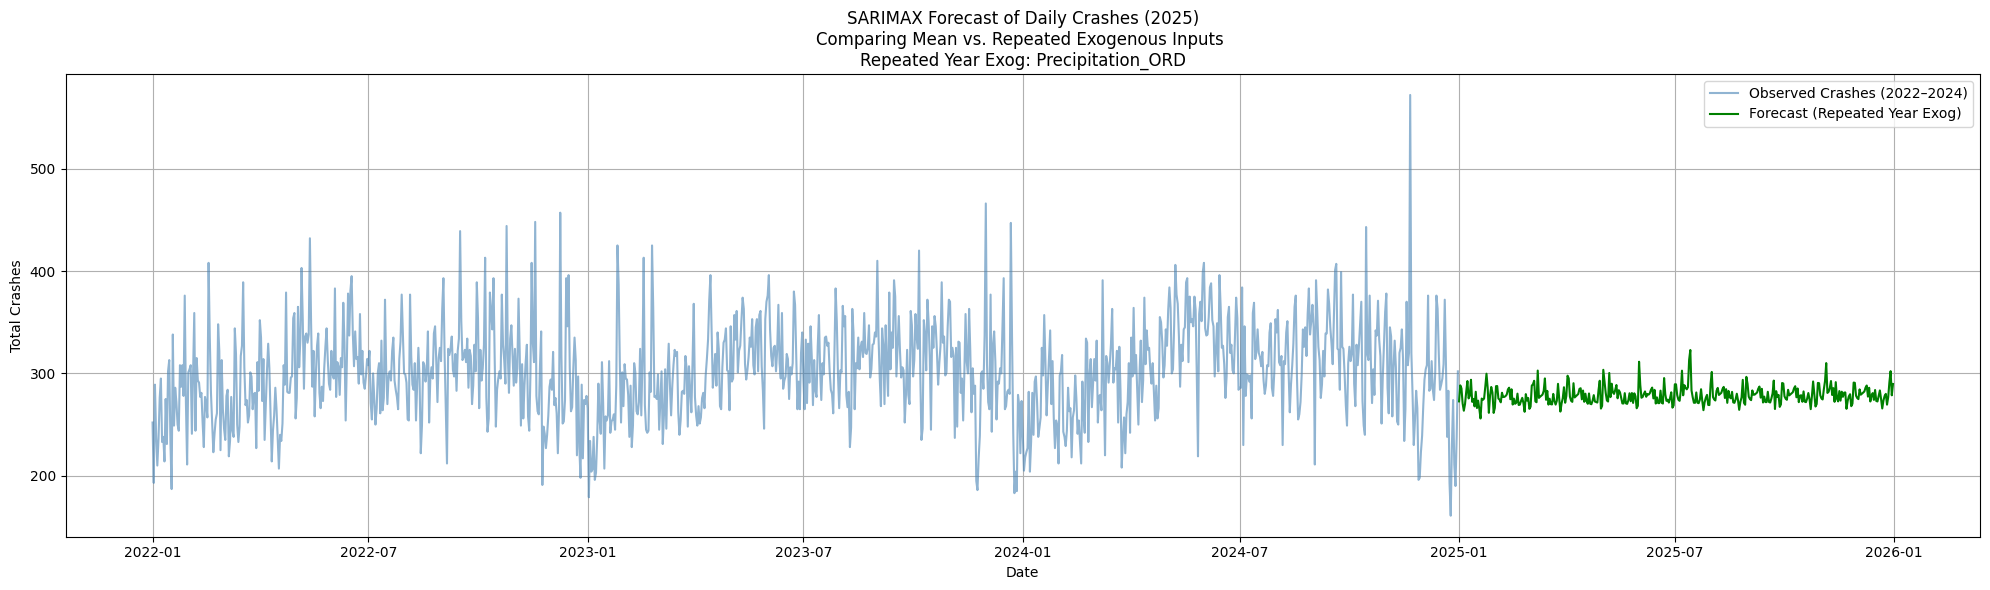

In [49]:
plt.figure(figsize=(20, 6))
# observed crash data
plt.plot(df_train_SARIMAX_22_24.index,
         df_train_SARIMAX_22_24["Total_Crashes"],
         label="Observed Crashes (2022–2024)", color="steelblue", alpha=0.6)

# # Model 2 – Forecast using repeated last year of exog
plt.plot(forecast_mean_2.index,
         forecast_mean_2,
         label="Forecast (Repeated Year Exog)", color="green")

# Formatting
plt.title("SARIMAX Forecast of Daily Crashes (2025)\nComparing Mean vs. Repeated Exogenous Inputs \nRepeated Year Exog: Precipitation_ORD")
plt.xlabel("Date")
plt.ylabel("Total Crashes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Summary of the two SARIMAX models:

Model 1: Using the mean Exogenous Value
For all future days, it uses the average precipitation value from the training period (2022–2024). It assumes the weather (precipitation) in the future will be typical or average. This leads to a FLAT forecast, since the weather input doesn't vary.

Model 2: Using the previous year of exogenous values
This model takes the actual precipitation values from the last year (2024) and repeats them into 2025. It assumes the future weather will follow a similar seasonal pattern as the most recent year. This produces a more realistic and seasonally driven forecast with day-to-day variation. 

------------------
## How well does SARIMAX model the actual data? Is this the best model to use?
Let's explore how well does the SARIMAX model fit the actual data. Does it have large residuals?

c:\Users\chris\Documents\Senior_Project\CT_SeniorProject\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\chris\Documents\Senior_Project\CT_SeniorProject\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


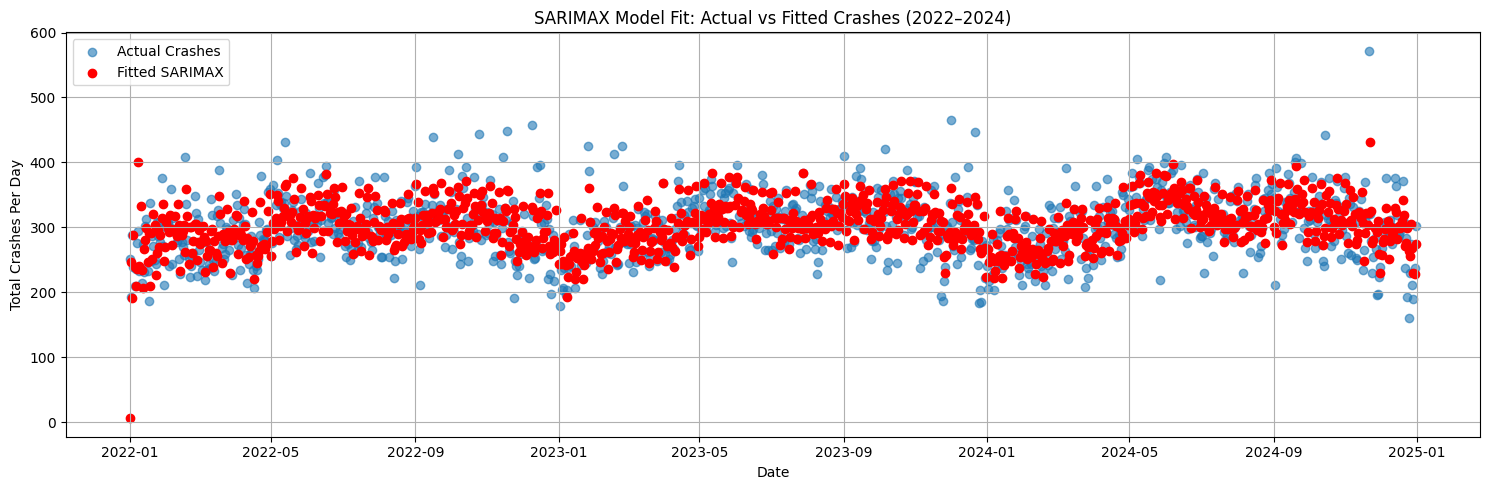

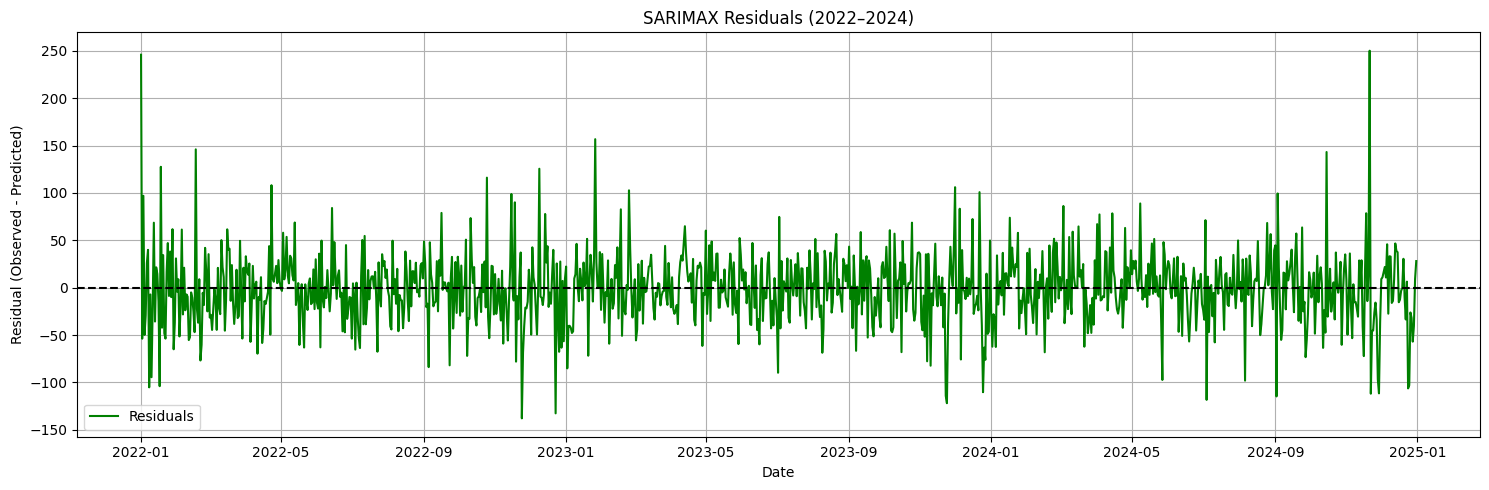

In [50]:

# --- Step 1: Prepare the data (2022–2024) ---
#df_full = df_full.asfreq("D")  # Ensure daily frequency

# --- Step 2: Define variables ---
endog = df_train_SARIMAX_22_24['Total_Crashes']
exog = df_train_SARIMAX_22_24[['Precipitation_ORD']]

# --- Step 3: Fit SARIMAX model ---
model = SARIMAX(endog, exog=exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
results = model.fit(disp=False)

# --- Step 4: Get fitted values and residuals ---
predicted = results.fittedvalues
residuals = endog - predicted

# --- Plot observed vs. fitted values ---
plt.figure(figsize=(15, 5))
plt.scatter(endog.index, endog, label="Actual Crashes", alpha=0.6)
plt.scatter(predicted.index, predicted, label="Fitted SARIMAX", color="red")
plt.title("SARIMAX Model Fit: Actual vs Fitted Crashes (2022–2024)")
plt.xlabel("Date")
plt.ylabel("Total Crashes Per Day")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# --- Step 5: Plot residuals ---
plt.figure(figsize=(15, 5))
plt.plot(residuals, label='Residuals', color='green')
plt.axhline(0, color='black', linestyle='--')
plt.title("SARIMAX Residuals (2022–2024)")
plt.xlabel("Date")
plt.ylabel("Residual (Observed - Predicted)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

These residuals actually seem fairly large. It looks like they average around 50. 

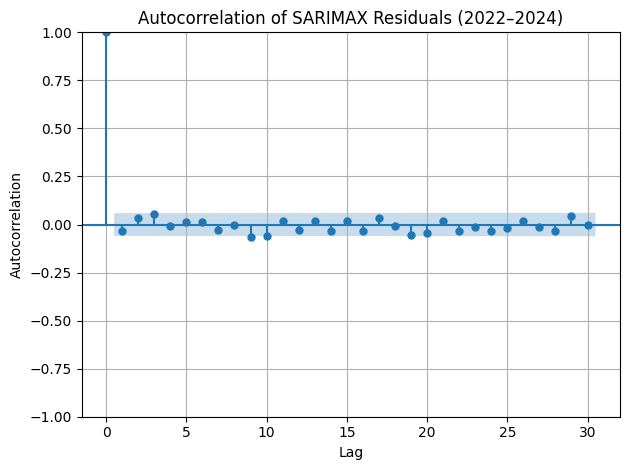

In [51]:
# Plot autocorrelation of residuals
plot_acf(residuals.dropna(), lags=30)
plt.title("Autocorrelation of SARIMAX Residuals (2022–2024)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.tight_layout()
plt.show()

There doesn't seem to be any large values, patterns or spikes. This means the residuals are random and there isn't any autocorrelation at any lag.

In [52]:
# RMSE
rmse = np.sqrt(mean_squared_error(endog.dropna(), predicted.dropna()))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 37.82


The RMSE for this model is 37.82. This is 

-------------------
## Running SARIMAX on different variables and comparing RMSE
Which variables will forecast the data best in terms of weather and also airport?

Below, let's create a loop to do that

In [53]:
from sklearn.metrics import mean_squared_error

# Define target variable (endogenous)
endog = df_train_SARIMAX_22_24['Total_Crashes']

# create difference variables
df_train_SARIMAX_22_24['Precipitation_Diff'] = df_train_SARIMAX_22_24['Precipitation_ORD'] - df_train_SARIMAX_22_24['Precipitation_MDW']
df_train_SARIMAX_22_24['Avg_Temperature_Diff'] = df_train_SARIMAX_22_24['Avg_Temperature_ORD'] - df_train_SARIMAX_22_24['Avg_Temperature_MDW']
df_train_SARIMAX_22_24['Snowfall_Diff'] = df_train_SARIMAX_22_24['Snowfall_ORD'] - df_train_SARIMAX_22_24['Snowfall_MDW']

# STEP 3: Weather variables to compare
weather_vars = [
    ['Precipitation_ORD'],
    ['Precipitation_MDW'],
    ['Precipitation_Diff'],
    ['Avg_Temperature_ORD'],
    ['Avg_Temperature_MDW'],
    ['Avg_Temperature_Diff'],
    ['Snowfall_ORD'],
    ['Snowfall_MDW'],
    ['Snowfall_Diff']
]

# STEP 4: Loop through variables and evaluate SARIMAX model
results_list = []

for var in weather_vars:
    try:
        exog = df_train_SARIMAX_22_24[var]
        model = SARIMAX(endog, exog=exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
        results = model.fit(disp=False)
        predicted = results.fittedvalues
        rmse = np.sqrt(mean_squared_error(endog.dropna(), predicted.dropna()))
        results_list.append((var[0], rmse))
    except Exception as e:
        results_list.append((var[0], f"Error: {str(e)}"))

# STEP 5: Create and print results DataFrame
results_df = pd.DataFrame(results_list, columns=["Variable", "RMSE"])
print(results_df.sort_values("RMSE"))


c:\Users\chris\Documents\Senior_Project\CT_SeniorProject\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\chris\Documents\Senior_Project\CT_SeniorProject\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\chris\Documents\Senior_Project\CT_SeniorProject\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\chris\Documents\Senior_Project\CT_SeniorProject\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\chris\Documents\Sen

               Variable       RMSE
6          Snowfall_ORD  37.694579
8         Snowfall_Diff  37.694579
0     Precipitation_ORD  37.823025
1     Precipitation_MDW  38.083611
4   Avg_Temperature_MDW  38.317051
3   Avg_Temperature_ORD  38.361117
2    Precipitation_Diff  38.451718
5  Avg_Temperature_Diff  38.474338
7          Snowfall_MDW  38.474819


### RMSE Comparisons (All)

Prophet model:
   Precipitation_ORD:  41.96605599225603
   Precipitation_MDW:  42.04963700253742

SARIMAX:
- Snowfall_ORD:  37.694579
- Snowfall_Diff:  37.694579
- Precipitation_ORD:  37.823025
- Precipitation_MDW:  38.083611
- Avg_Temperature_MDW:  38.317051
- Avg_Temperature_ORD:  38.361117
- Precipitation_Diff:  38.451718
- Avg_Temperature_Diff:  38.474338
- Snowfall_MDW:  38.474819

The smallest RMSE value overall are both of the Snowfall models using measurements from both airports. However, all of these RMSEs are extremely similar, and there isn't enough of a difference to say that one model is better than the other.

### Exploring SARIMAX with non-weather related variables

There are many other variables in the dataset that could be used to predict crash rates. Let's explore some of these variables and see how they perform in terms of RMSE.
- Road Defect
- Road Surface Condition
- Lighting Condition

In [55]:
# filter df by date range 2022-2024 and only include LIGHTING_CONDITION, TRAFFIC_CONTROL_DEVICE, ROAD_DEFECT, and CRASH_DATE columns
df = df[(df["CRASH_DATE"] >= "2022-01-01") & (df["CRASH_DATE"] <= "2024-12-31")]
df = df[["CRASH_DATE", "LIGHTING_CONDITION", "TRAFFIC_CONTROL_DEVICE", "ROAD_DEFECT"]]
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 331163 entries, 437571 to 768733
Data columns (total 4 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   CRASH_DATE              331163 non-null  datetime64[ns]
 1   LIGHTING_CONDITION      331163 non-null  object        
 2   TRAFFIC_CONTROL_DEVICE  331163 non-null  object        
 3   ROAD_DEFECT             331163 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 12.6+ MB


In [56]:
# Ensure CRASH_DATE is in datetime format
df['CRASH_DATE'] = pd.to_datetime(df['CRASH_DATE'])

df_crashes_per_day = df.groupby("CRASH_DATE").size().reset_index(name="Total_Crashes")

# Flag 1: Poor lighting
poor_lighting_values = ['DUSK', 'DAWN', 'DARKNESS, LIGHTED ROAD', 'DARKNESS']
df['Poor_Lighting_Flag'] = df['LIGHTING_CONDITION'].isin(poor_lighting_values).astype(int)

# Flag 2: No control device
df['No_Control_Flag'] = (df['TRAFFIC_CONTROL_DEVICE'] == 'NO CONTROLS').astype(int)

# Flag 3: Road defect present (anything except "NO DEFECTS")
df['Road_Defect_Flag'] = (df['ROAD_DEFECT'] != 'NO DEFECTS').astype(int)

# Group by CRASH_DATE to get daily proportions
daily_flags = df.groupby('CRASH_DATE')[[
    'Poor_Lighting_Flag',
    'No_Control_Flag',
    'Road_Defect_Flag'
]].mean().reset_index()

# Optional: Merge with your daily crash totals (df_crashes_per_day)
df_features = df_crashes_per_day.merge(daily_flags, on="CRASH_DATE", how="left")

# Preview the result
df_features.head()

CRASH_DATE  Total_Crashes  Poor_Lighting_Flag  No_Control_Flag  \
0 2022-01-01            252            0.702381         0.543651   
1 2022-01-02            193            0.383420         0.523316   
2 2022-01-03            289            0.325260         0.525952   
3 2022-01-04            239            0.355649         0.506276   
4 2022-01-05            210            0.371429         0.590476   

   Road_Defect_Flag  
0          0.250000  
1          0.300518  
2          0.207612  
3          0.200837  
4          0.228571

The dataset was set up to include these variables as binary flags. We can use these to predict crash rates. For a given crash, if the flag was set to 1, then the crash was affected by that condition. If it was set to 0, then the crash was not affected by that condition. 

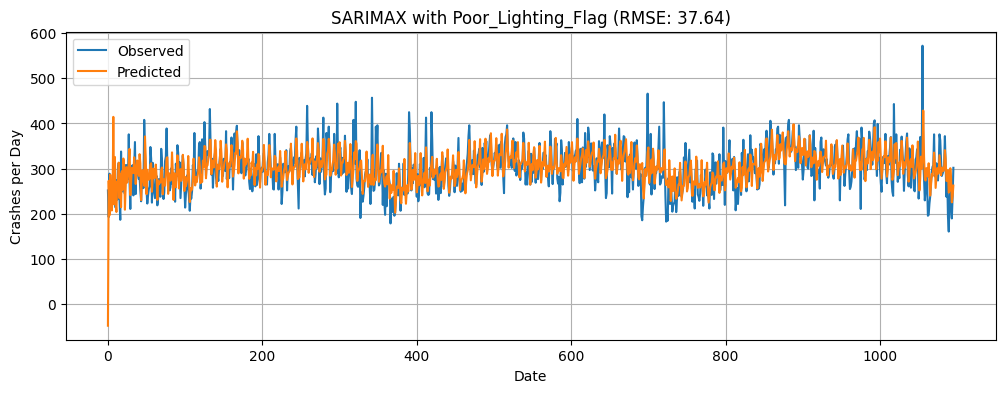

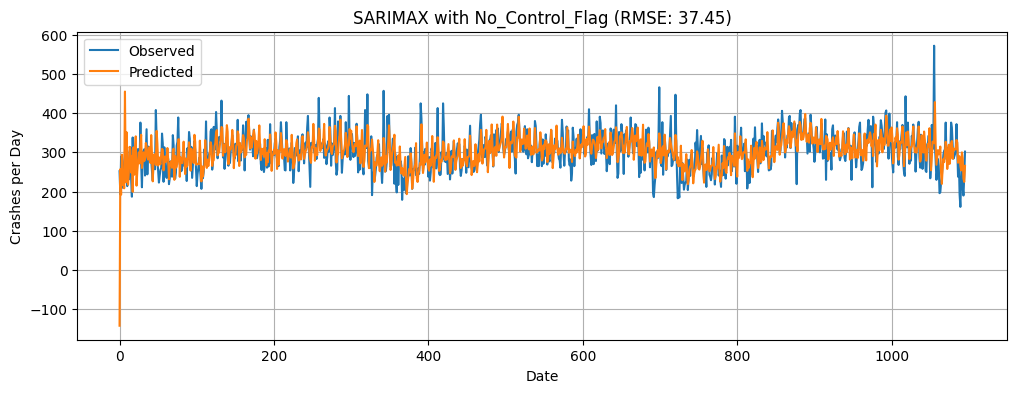

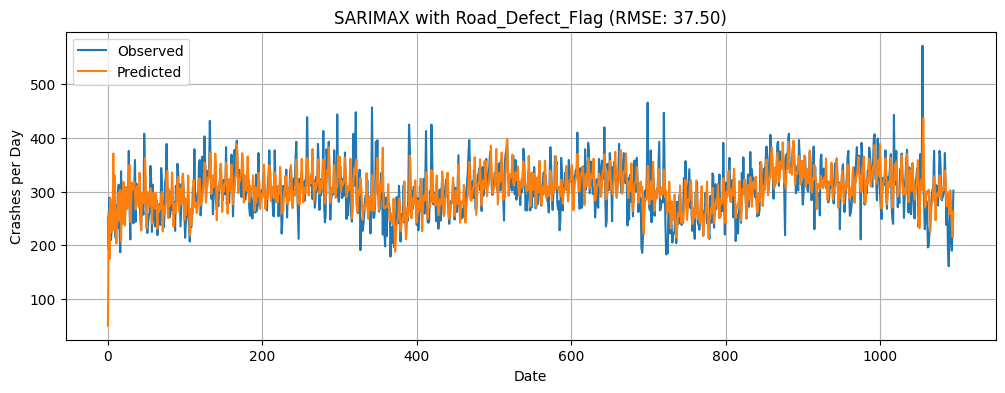

Poor_Lighting_Flag: RMSE = 37.64
No_Control_Flag: RMSE = 37.45
Road_Defect_Flag: RMSE = 37.50


In [57]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

# Define target and list of explanatory variables
endog = df_features["Total_Crashes"]
exog_variables = ["Poor_Lighting_Flag", "No_Control_Flag", "Road_Defect_Flag"]
sarimax_results = []

for var in exog_variables:
    exog = df_features[[var]]
    model = SARIMAX(endog, exog=exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    results = model.fit(disp=False)

    predictions = results.fittedvalues
    rmse = np.sqrt(mean_squared_error(endog[1:], predictions[1:]))  # skip first diff value
    sarimax_results.append((var, rmse))

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(endog, label="Observed")
    plt.plot(predictions, label="Predicted")
    plt.title(f"SARIMAX with {var} (RMSE: {rmse:.2f})")
    plt.xlabel("Date")
    plt.ylabel("Crashes per Day")
    plt.legend()
    plt.grid(True)
    plt.show()

# Print summary
for var, rmse in sarimax_results:
    print(f"{var}: RMSE = {rmse:.2f}")

The three graphs show the SARIMAX model with the different variables. The first graph shows the SARIMAX model with the Poor Lighting Flag. The second graph shows the SARIMAX model with No Traffic Control Device Flag. The third graph shows the SARIMAX model with the Road Defect Flag.

All three models have extremely similar RMSE values. The No Traffic Control variable barely has the lowest value, but they are all so similar that it is not significant. 

# Section 6 - Conclusion

In this project, we explored the use of time-series modeling techniques to analyze and forecast traffic crashes in Chicago. We used a combination of Prophet forecasting, Holt-Winters smoothing, and SARIMAX regression to understand the patterns in the data and make predictions about future crash rates.

We found that the Prophet model was able to capture the seasonal patterns in the data well, but it struggled with extreme values and outliers. The Holt-Winters model was able to capture the weekly and yearly seasonality, but it also struggled with extreme values. The SARIMAX model was able to incorporate weather data into the forecasting process, but it also struggled with extreme values and outliers.

Overall, we found that the SARIMAX model with weather data was the most accurate in predicting crash rates, with a root mean squared error (RMSE) of 38.47 crashes per day. The Prophet model had an RMSE of 42.38 crashes per day, and the Holt-Winters model had an RMSE of 35.53 crashes per day.

Incorporating external variables through SARIMAX modeling added additional nuance. Weather features like precipitation and temperature had a modest impact on predictive accuracy, while crash condition flags (e.g., poor lighting, no traffic controls, road defects) showed some improvement as well. However, these variables did not dramatically outperform lag-based models alone, reinforcing the idea that seasonal structure and autoregression carry the majority of the predictive power.

Ultimately, this project supports the conclusion that crash rates in a city like Chicago follow structured, predictable patterns, driven by time-based cycles and occasionally modulated by external conditions. While no model can fully capture the randomness and complexity of real-world crashes, these methods provide a valuable foundation for short-term forecasting and safety planning. Future work could extend this analysis with spatial data or real-time traffic volume to improve accuracy and target high-risk periods more effectively.